In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

297


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:48<00:00,  1.24it/s]


In [12]:
Dataset = 'Small Village Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 32.20513725280762 [s] ... size 1445.218304 MB


In [14]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 49.327698707580566 [s] ... size 1926.957056 MB


In [15]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [19]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:58<00:00,  1.02it/s]


In [20]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 325771.18it/s]


In [21]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [22]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [23]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [24]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [25]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [26]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [35]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


In [36]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 36746.48it/s]


In [37]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [38]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [39]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [40]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [41]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [42]:
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [43]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [12:42<00:00, 12.71s/it]


In [44]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 361059.17it/s]


In [45]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [46]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [47]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [48]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [49]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [50]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [51]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [52]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:06<00:00,  2.11s/it]


In [53]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 342159.40it/s]


In [54]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [55]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [56]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [57]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [58]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [59]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [60]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


In [61]:
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 381011.72it/s]


In [62]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [63]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [64]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [65]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [66]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [67]:
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [68]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:54<00:00,  1.10it/s]


In [69]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 108825.18it/s]


In [70]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [71]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [72]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [73]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [74]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [75]:
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [73]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [74]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [75]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [76]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [77]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:40<00:00,  3.68s/it]


In [78]:
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 140709.11it/s]


In [79]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [80]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [81]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [82]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [83]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [84]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [85]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [86]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [87]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [88]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [89]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [90]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [91]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:35,  3.58s/it]


Number of matches 34199
Number of matches After Lowe's Ratio 515
Number of Robust matches 180




  3%|▎         | 2/61 [00:08<03:49,  3.89s/it]


Number of matches 35002
Number of matches After Lowe's Ratio 702
Number of Robust matches 264




  5%|▍         | 3/61 [00:12<03:51,  3.99s/it]


Number of matches 30176
Number of matches After Lowe's Ratio 571
Number of Robust matches 205




  7%|▋         | 4/61 [00:16<03:41,  3.88s/it]


Number of matches 30093
Number of matches After Lowe's Ratio 680
Number of Robust matches 286




  8%|▊         | 5/61 [00:20<03:40,  3.93s/it]


Number of matches 32458
Number of matches After Lowe's Ratio 457
Number of Robust matches 242




 10%|▉         | 6/61 [00:24<03:40,  4.02s/it]


Number of matches 40164
Number of matches After Lowe's Ratio 1542
Number of Robust matches 1282




 11%|█▏        | 7/61 [00:29<04:02,  4.48s/it]


Number of matches 37252
Number of matches After Lowe's Ratio 1566
Number of Robust matches 1030




 13%|█▎        | 8/61 [00:35<04:08,  4.68s/it]


Number of matches 29747
Number of matches After Lowe's Ratio 919
Number of Robust matches 571




 15%|█▍        | 9/61 [00:38<03:51,  4.44s/it]


Number of matches 30558
Number of matches After Lowe's Ratio 767
Number of Robust matches 409




 16%|█▋        | 10/61 [00:43<03:42,  4.37s/it]


Number of matches 32053
Number of matches After Lowe's Ratio 688
Number of Robust matches 295




 18%|█▊        | 11/61 [00:47<03:43,  4.46s/it]


Number of matches 32381
Number of matches After Lowe's Ratio 598
Number of Robust matches 171




 20%|█▉        | 12/61 [00:52<03:36,  4.42s/it]


Number of matches 32496
Number of matches After Lowe's Ratio 610
Number of Robust matches 152




 21%|██▏       | 13/61 [00:57<03:42,  4.63s/it]


Number of matches 54658
Number of matches After Lowe's Ratio 248
Number of Robust matches 69




 23%|██▎       | 14/61 [01:08<05:14,  6.69s/it]


Number of matches 86841
Number of matches After Lowe's Ratio 208
Number of Robust matches 119




 25%|██▍       | 15/61 [01:18<05:56,  7.76s/it]


Number of matches 45969
Number of matches After Lowe's Ratio 419
Number of Robust matches 207




 26%|██▌       | 16/61 [01:25<05:31,  7.36s/it]


Number of matches 33352
Number of matches After Lowe's Ratio 740
Number of Robust matches 275




 28%|██▊       | 17/61 [01:29<04:41,  6.40s/it]


Number of matches 32253
Number of matches After Lowe's Ratio 635
Number of Robust matches 235




 30%|██▉       | 18/61 [01:33<04:06,  5.72s/it]


Number of matches 36758
Number of matches After Lowe's Ratio 526
Number of Robust matches 156




 31%|███       | 19/61 [01:38<03:51,  5.52s/it]


Number of matches 32492
Number of matches After Lowe's Ratio 392
Number of Robust matches 157




 33%|███▎      | 20/61 [01:42<03:29,  5.11s/it]


Number of matches 36392
Number of matches After Lowe's Ratio 294
Number of Robust matches 135




 34%|███▍      | 21/61 [01:48<03:24,  5.12s/it]


Number of matches 42773
Number of matches After Lowe's Ratio 982
Number of Robust matches 657




 36%|███▌      | 22/61 [01:55<03:46,  5.80s/it]


Number of matches 53307
Number of matches After Lowe's Ratio 1744
Number of Robust matches 1296




 38%|███▊      | 23/61 [02:02<03:56,  6.22s/it]


Number of matches 38624
Number of matches After Lowe's Ratio 1118
Number of Robust matches 843




 39%|███▉      | 24/61 [02:07<03:37,  5.89s/it]


Number of matches 27994
Number of matches After Lowe's Ratio 285
Number of Robust matches 134




 41%|████      | 25/61 [02:11<03:04,  5.11s/it]


Number of matches 27814
Number of matches After Lowe's Ratio 324
Number of Robust matches 115




 43%|████▎     | 26/61 [02:14<02:42,  4.65s/it]


Number of matches 34801
Number of matches After Lowe's Ratio 207
Number of Robust matches 56




 44%|████▍     | 27/61 [02:19<02:41,  4.74s/it]


Number of matches 34671
Number of matches After Lowe's Ratio 530
Number of Robust matches 161




 46%|████▌     | 28/61 [02:24<02:37,  4.76s/it]


Number of matches 44043
Number of matches After Lowe's Ratio 278
Number of Robust matches 90




 48%|████▊     | 29/61 [02:32<03:09,  5.91s/it]


Number of matches 65763
Number of matches After Lowe's Ratio 194
Number of Robust matches 86




 49%|████▉     | 30/61 [02:42<03:33,  6.89s/it]


Number of matches 51581
Number of matches After Lowe's Ratio 263
Number of Robust matches 117




 51%|█████     | 31/61 [02:49<03:26,  6.88s/it]


Number of matches 34879
Number of matches After Lowe's Ratio 340
Number of Robust matches 97




 52%|█████▏    | 32/61 [02:53<02:54,  6.01s/it]


Number of matches 24551
Number of matches After Lowe's Ratio 455
Number of Robust matches 130




 54%|█████▍    | 33/61 [02:55<02:21,  5.06s/it]


Number of matches 26311
Number of matches After Lowe's Ratio 449
Number of Robust matches 144




 56%|█████▌    | 34/61 [02:59<02:04,  4.60s/it]


Number of matches 27904
Number of matches After Lowe's Ratio 395
Number of Robust matches 125




 57%|█████▋    | 35/61 [03:02<01:50,  4.26s/it]


Number of matches 32478
Number of matches After Lowe's Ratio 399
Number of Robust matches 160




 59%|█████▉    | 36/61 [03:07<01:51,  4.46s/it]


Number of matches 43545
Number of matches After Lowe's Ratio 726
Number of Robust matches 543




 61%|██████    | 37/61 [03:14<02:02,  5.11s/it]


Number of matches 54459
Number of matches After Lowe's Ratio 1134
Number of Robust matches 671




 62%|██████▏   | 38/61 [03:21<02:14,  5.83s/it]


Number of matches 37887
Number of matches After Lowe's Ratio 1097
Number of Robust matches 865




 64%|██████▍   | 39/61 [03:26<01:59,  5.42s/it]


Number of matches 27016
Number of matches After Lowe's Ratio 650
Number of Robust matches 467




 66%|██████▌   | 40/61 [03:28<01:35,  4.53s/it]


Number of matches 15395
Number of matches After Lowe's Ratio 275
Number of Robust matches 144




 67%|██████▋   | 41/61 [03:30<01:11,  3.55s/it]


Number of matches 18483
Number of matches After Lowe's Ratio 285
Number of Robust matches 110




 69%|██████▉   | 42/61 [03:32<00:58,  3.06s/it]


Number of matches 25066
Number of matches After Lowe's Ratio 463
Number of Robust matches 137




 70%|███████   | 43/61 [03:35<00:59,  3.29s/it]


Number of matches 39986
Number of matches After Lowe's Ratio 379
Number of Robust matches 92




 72%|███████▏  | 44/61 [03:43<01:15,  4.46s/it]


Number of matches 61834
Number of matches After Lowe's Ratio 163
Number of Robust matches 80




 74%|███████▍  | 45/61 [03:56<01:54,  7.15s/it]


Number of matches 95237
Number of matches After Lowe's Ratio 198
Number of Robust matches 118




 75%|███████▌  | 46/61 [04:08<02:07,  8.52s/it]


Number of matches 60829
Number of matches After Lowe's Ratio 193
Number of Robust matches 102




 77%|███████▋  | 47/61 [04:16<01:57,  8.37s/it]


Number of matches 37081
Number of matches After Lowe's Ratio 209
Number of Robust matches 107




 79%|███████▊  | 48/61 [04:20<01:32,  7.14s/it]


Number of matches 27312
Number of matches After Lowe's Ratio 294
Number of Robust matches 94




 80%|████████  | 49/61 [04:23<01:09,  5.77s/it]


Number of matches 15737
Number of matches After Lowe's Ratio 322
Number of Robust matches 87




 82%|████████▏ | 50/61 [04:24<00:49,  4.46s/it]


Number of matches 24741
Number of matches After Lowe's Ratio 324
Number of Robust matches 113




 84%|████████▎ | 51/61 [04:27<00:41,  4.16s/it]


Number of matches 32474
Number of matches After Lowe's Ratio 462
Number of Robust matches 310




 85%|████████▌ | 52/61 [04:32<00:38,  4.27s/it]


Number of matches 46462
Number of matches After Lowe's Ratio 854
Number of Robust matches 571




 87%|████████▋ | 53/61 [04:40<00:42,  5.30s/it]


Number of matches 57608
Number of matches After Lowe's Ratio 1229
Number of Robust matches 908




 89%|████████▊ | 54/61 [04:48<00:43,  6.24s/it]


Number of matches 56279
Number of matches After Lowe's Ratio 1256
Number of Robust matches 1040




 90%|█████████ | 55/61 [04:56<00:40,  6.75s/it]


Number of matches 39926
Number of matches After Lowe's Ratio 676
Number of Robust matches 444




 92%|█████████▏| 56/61 [05:01<00:31,  6.25s/it]


Number of matches 30586
Number of matches After Lowe's Ratio 321
Number of Robust matches 234




 93%|█████████▎| 57/61 [05:05<00:21,  5.41s/it]


Number of matches 25532
Number of matches After Lowe's Ratio 224
Number of Robust matches 99




 95%|█████████▌| 58/61 [05:08<00:14,  4.75s/it]


Number of matches 21565
Number of matches After Lowe's Ratio 256
Number of Robust matches 84




 97%|█████████▋| 59/61 [05:11<00:08,  4.16s/it]


Number of matches 47461
Number of matches After Lowe's Ratio 228
Number of Robust matches 89




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 69453
Number of matches After Lowe's Ratio 204
Number of Robust matches 127




  2%|▏         | 1/60 [00:04<04:01,  4.09s/it]


Number of matches 43080
Number of matches After Lowe's Ratio 476
Number of Robust matches 137




  3%|▎         | 2/60 [00:12<05:04,  5.25s/it]


Number of matches 60518
Number of matches After Lowe's Ratio 449
Number of Robust matches 165




  5%|▌         | 3/60 [00:20<05:46,  6.07s/it]


Number of matches 40645
Number of matches After Lowe's Ratio 161
Number of Robust matches 52




  7%|▋         | 4/60 [00:25<05:35,  5.99s/it]


Number of matches 34816
Number of matches After Lowe's Ratio 316
Number of Robust matches 143




  8%|▊         | 5/60 [00:30<05:03,  5.52s/it]


Number of matches 33906
Number of matches After Lowe's Ratio 589
Number of Robust matches 245




 10%|█         | 6/60 [00:35<04:45,  5.29s/it]


Number of matches 34306
Number of matches After Lowe's Ratio 554
Number of Robust matches 198




 12%|█▏        | 7/60 [00:39<04:22,  4.96s/it]


Number of matches 30653
Number of matches After Lowe's Ratio 737
Number of Robust matches 311




 13%|█▎        | 8/60 [00:42<03:55,  4.53s/it]


Number of matches 26414
Number of matches After Lowe's Ratio 774
Number of Robust matches 378




 15%|█▌        | 9/60 [00:45<03:26,  4.05s/it]


Number of matches 22910
Number of matches After Lowe's Ratio 826
Number of Robust matches 390




 17%|█▋        | 10/60 [00:48<03:05,  3.72s/it]


Number of matches 22843
Number of matches After Lowe's Ratio 1055
Number of Robust matches 700




 18%|█▊        | 11/60 [00:51<02:44,  3.36s/it]


Number of matches 23216
Number of matches After Lowe's Ratio 1022
Number of Robust matches 582




 20%|██        | 12/60 [00:54<02:35,  3.23s/it]


Number of matches 30508
Number of matches After Lowe's Ratio 792
Number of Robust matches 484




 22%|██▏       | 13/60 [00:58<02:47,  3.57s/it]


Number of matches 33067
Number of matches After Lowe's Ratio 848
Number of Robust matches 474




 23%|██▎       | 14/60 [01:02<02:55,  3.81s/it]


Number of matches 34821
Number of matches After Lowe's Ratio 828
Number of Robust matches 365




 25%|██▌       | 15/60 [01:07<03:01,  4.03s/it]


Number of matches 33892
Number of matches After Lowe's Ratio 520
Number of Robust matches 223




 27%|██▋       | 16/60 [01:11<03:03,  4.16s/it]


Number of matches 27929
Number of matches After Lowe's Ratio 538
Number of Robust matches 232




 28%|██▊       | 17/60 [01:15<02:51,  3.99s/it]


Number of matches 33854
Number of matches After Lowe's Ratio 438
Number of Robust matches 191




 30%|███       | 18/60 [01:20<02:57,  4.23s/it]


Number of matches 41142
Number of matches After Lowe's Ratio 510
Number of Robust matches 214




 32%|███▏      | 19/60 [01:26<03:14,  4.74s/it]


Number of matches 33056
Number of matches After Lowe's Ratio 231
Number of Robust matches 97




 33%|███▎      | 20/60 [01:30<03:00,  4.51s/it]


Number of matches 27945
Number of matches After Lowe's Ratio 370
Number of Robust matches 125




 35%|███▌      | 21/60 [01:33<02:46,  4.27s/it]


Number of matches 39280
Number of matches After Lowe's Ratio 598
Number of Robust matches 301




 37%|███▋      | 22/60 [01:39<02:57,  4.67s/it]


Number of matches 35020
Number of matches After Lowe's Ratio 666
Number of Robust matches 259




 38%|███▊      | 23/60 [01:43<02:46,  4.49s/it]


Number of matches 30181
Number of matches After Lowe's Ratio 680
Number of Robust matches 260




 40%|████      | 24/60 [01:47<02:31,  4.22s/it]


Number of matches 27761
Number of matches After Lowe's Ratio 983
Number of Robust matches 610




 42%|████▏     | 25/60 [01:50<02:18,  3.96s/it]


Number of matches 20441
Number of matches After Lowe's Ratio 1266
Number of Robust matches 1001




 43%|████▎     | 26/60 [01:52<01:51,  3.28s/it]


Number of matches 9484
Number of matches After Lowe's Ratio 741
Number of Robust matches 650




 45%|████▌     | 27/60 [01:52<01:23,  2.53s/it]


Number of matches 15669
Number of matches After Lowe's Ratio 521
Number of Robust matches 437




 47%|████▋     | 28/60 [01:54<01:11,  2.24s/it]


Number of matches 34109
Number of matches After Lowe's Ratio 876
Number of Robust matches 662




 48%|████▊     | 29/60 [01:59<01:37,  3.15s/it]


Number of matches 40934
Number of matches After Lowe's Ratio 1169
Number of Robust matches 725




 50%|█████     | 30/60 [02:05<01:58,  3.97s/it]


Number of matches 39357
Number of matches After Lowe's Ratio 877
Number of Robust matches 280




 52%|█████▏    | 31/60 [02:11<02:11,  4.52s/it]


Number of matches 38655
Number of matches After Lowe's Ratio 727
Number of Robust matches 275




 53%|█████▎    | 32/60 [02:16<02:08,  4.57s/it]


Number of matches 29950
Number of matches After Lowe's Ratio 580
Number of Robust matches 277




 55%|█████▌    | 33/60 [02:19<01:53,  4.22s/it]


Number of matches 25428
Number of matches After Lowe's Ratio 478
Number of Robust matches 271




 57%|█████▋    | 34/60 [02:23<01:48,  4.17s/it]


Number of matches 47461
Number of matches After Lowe's Ratio 408
Number of Robust matches 213




 58%|█████▊    | 35/60 [02:30<02:04,  4.96s/it]


Number of matches 38123
Number of matches After Lowe's Ratio 332
Number of Robust matches 172




 60%|██████    | 36/60 [02:35<01:58,  4.94s/it]


Number of matches 31812
Number of matches After Lowe's Ratio 299
Number of Robust matches 165




 62%|██████▏   | 37/60 [02:39<01:51,  4.85s/it]


Number of matches 37496
Number of matches After Lowe's Ratio 597
Number of Robust matches 288




 63%|██████▎   | 38/60 [02:45<01:48,  4.93s/it]


Number of matches 40383
Number of matches After Lowe's Ratio 618
Number of Robust matches 223




 65%|██████▌   | 39/60 [02:50<01:49,  5.21s/it]


Number of matches 36317
Number of matches After Lowe's Ratio 843
Number of Robust matches 331




 67%|██████▋   | 40/60 [02:55<01:39,  4.97s/it]


Number of matches 35360
Number of matches After Lowe's Ratio 1402
Number of Robust matches 910




 68%|██████▊   | 41/60 [02:59<01:27,  4.63s/it]


Number of matches 24648
Number of matches After Lowe's Ratio 1202
Number of Robust matches 788




 70%|███████   | 42/60 [03:00<01:08,  3.79s/it]


Number of matches 959
Number of matches After Lowe's Ratio 50
Number of Robust matches 36




 72%|███████▏  | 43/60 [03:01<00:48,  2.87s/it]


Number of matches 20233
Number of matches After Lowe's Ratio 108
Number of Robust matches 79




 73%|███████▎  | 44/60 [03:04<00:43,  2.73s/it]


Number of matches 36008
Number of matches After Lowe's Ratio 902
Number of Robust matches 754




 75%|███████▌  | 45/60 [03:08<00:50,  3.35s/it]


Number of matches 42174
Number of matches After Lowe's Ratio 1217
Number of Robust matches 801




 77%|███████▋  | 46/60 [03:14<00:57,  4.10s/it]


Number of matches 37208
Number of matches After Lowe's Ratio 705
Number of Robust matches 275




 78%|███████▊  | 47/60 [03:19<00:56,  4.32s/it]


Number of matches 33717
Number of matches After Lowe's Ratio 621
Number of Robust matches 209




 80%|████████  | 48/60 [03:24<00:53,  4.44s/it]


Number of matches 31670
Number of matches After Lowe's Ratio 468
Number of Robust matches 208




 82%|████████▏ | 49/60 [03:27<00:45,  4.15s/it]


Number of matches 22741
Number of matches After Lowe's Ratio 369
Number of Robust matches 233




 83%|████████▎ | 50/60 [03:30<00:38,  3.85s/it]


Number of matches 39097
Number of matches After Lowe's Ratio 528
Number of Robust matches 232




 85%|████████▌ | 51/60 [03:35<00:36,  4.03s/it]


Number of matches 21927
Number of matches After Lowe's Ratio 289
Number of Robust matches 142




 87%|████████▋ | 52/60 [03:38<00:30,  3.79s/it]


Number of matches 34268
Number of matches After Lowe's Ratio 179
Number of Robust matches 76




 88%|████████▊ | 53/60 [03:43<00:28,  4.00s/it]


Number of matches 35120
Number of matches After Lowe's Ratio 465
Number of Robust matches 164




 90%|█████████ | 54/60 [03:47<00:25,  4.26s/it]


Number of matches 36437
Number of matches After Lowe's Ratio 585
Number of Robust matches 198




 92%|█████████▏| 55/60 [03:52<00:22,  4.42s/it]


Number of matches 34276
Number of matches After Lowe's Ratio 648
Number of Robust matches 291




 93%|█████████▎| 56/60 [03:57<00:17,  4.38s/it]


Number of matches 31206
Number of matches After Lowe's Ratio 1170
Number of Robust matches 876




 95%|█████████▌| 57/60 [04:00<00:12,  4.11s/it]


Number of matches 23731
Number of matches After Lowe's Ratio 1297
Number of Robust matches 1084




 97%|█████████▋| 58/60 [04:03<00:07,  3.64s/it]


Number of matches 9809
Number of matches After Lowe's Ratio 1007
Number of Robust matches 790




 98%|█████████▊| 59/60 [04:03<00:02,  2.79s/it]


Number of matches 17434
Number of matches After Lowe's Ratio 846
Number of Robust matches 635




In [92]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.026795387268066406 [s] ... size 0.006368 MB


In [93]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.002952098846435547 [s] ... size 0.006296 MB


In [94]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [95]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [96]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [97]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:21,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 226
Number of Robust matches 61




  3%|▎         | 2/61 [00:02<01:19,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 332
Number of Robust matches 103




  5%|▍         | 3/61 [00:04<01:23,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 279
Number of Robust matches 85




  7%|▋         | 4/61 [00:05<01:20,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 350
Number of Robust matches 146




  8%|▊         | 5/61 [00:06<01:16,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 232
Number of Robust matches 98




 10%|▉         | 6/61 [00:08<01:15,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 415
Number of Robust matches 214




 11%|█▏        | 7/61 [00:09<01:12,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 422
Number of Robust matches 236




 13%|█▎        | 8/61 [00:11<01:16,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 335
Number of Robust matches 180




 15%|█▍        | 9/61 [00:12<01:12,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 422
Number of Robust matches 211




 16%|█▋        | 10/61 [00:13<01:10,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 339
Number of Robust matches 124




 18%|█▊        | 11/61 [00:15<01:08,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 241
Number of Robust matches 64




 20%|█▉        | 12/61 [00:16<01:07,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 325
Number of Robust matches 64




 21%|██▏       | 13/61 [00:18<01:11,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 119
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1707
Number of Robust matches New 8




 23%|██▎       | 14/61 [00:19<01:09,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 91
Number of Robust matches 19


Number of matches After Lowe's Ratio New 1715
Number of Robust matches New 8




 25%|██▍       | 15/61 [00:21<01:08,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 122
Number of Robust matches 22


Number of matches After Lowe's Ratio New 1797
Number of Robust matches New 16




 26%|██▌       | 16/61 [00:22<01:04,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 261
Number of Robust matches 82




 28%|██▊       | 17/61 [00:24<01:06,  1.50s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 240
Number of Robust matches 60




 30%|██▉       | 18/61 [00:25<01:02,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 52




 31%|███       | 19/61 [00:27<01:00,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 258
Number of Robust matches 64




 33%|███▎      | 20/61 [00:28<00:57,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 191
Number of Robust matches 53




 34%|███▍      | 21/61 [00:29<00:55,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 246
Number of Robust matches 116




 36%|███▌      | 22/61 [00:31<00:56,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 476
Number of Robust matches 290




 38%|███▊      | 23/61 [00:32<00:53,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 337
Number of Robust matches 192




 39%|███▉      | 24/61 [00:34<00:51,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 227
Number of Robust matches 57




 41%|████      | 25/61 [00:35<00:50,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 61




 43%|████▎     | 26/61 [00:36<00:48,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 188
Number of Robust matches 32




 44%|████▍     | 27/61 [00:38<00:50,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 239
Number of Robust matches 60




 46%|████▌     | 28/61 [00:39<00:48,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 150
Number of Robust matches 29




 48%|████▊     | 29/61 [00:41<00:47,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 84
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1700
Number of Robust matches New 7




 49%|████▉     | 30/61 [00:42<00:46,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 115
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1741
Number of Robust matches New 10




 51%|█████     | 31/61 [00:44<00:46,  1.56s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 33




 52%|█████▏    | 32/61 [00:46<00:43,  1.50s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 277
Number of Robust matches 81




 54%|█████▍    | 33/61 [00:47<00:41,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 257
Number of Robust matches 81




 56%|█████▌    | 34/61 [00:48<00:39,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 63




 57%|█████▋    | 35/61 [00:50<00:37,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 255
Number of Robust matches 86




 59%|█████▉    | 36/61 [00:51<00:37,  1.50s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 260
Number of Robust matches 123




 61%|██████    | 37/61 [00:53<00:35,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 285
Number of Robust matches 135




 62%|██████▏   | 38/61 [00:54<00:32,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 383
Number of Robust matches 247




 64%|██████▍   | 39/61 [00:55<00:30,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 323
Number of Robust matches 154




 66%|██████▌   | 40/61 [00:57<00:29,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 86




 67%|██████▋   | 41/61 [00:59<00:29,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 84




 69%|██████▉   | 42/61 [01:00<00:27,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 290
Number of Robust matches 93




 70%|███████   | 43/61 [01:01<00:25,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 222
Number of Robust matches 63




 72%|███████▏  | 44/61 [01:03<00:24,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 93
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1658
Number of Robust matches New 8




 74%|███████▍  | 45/61 [01:04<00:23,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1680
Number of Robust matches New 7




 75%|███████▌  | 46/61 [01:06<00:23,  1.57s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 84
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1693
Number of Robust matches New 7




 77%|███████▋  | 47/61 [01:08<00:21,  1.56s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 93
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1830
Number of Robust matches New 14




 79%|███████▊  | 48/61 [01:09<00:19,  1.51s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 200
Number of Robust matches 36




 80%|████████  | 49/61 [01:10<00:17,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 318
Number of Robust matches 76




 82%|████████▏ | 50/61 [01:12<00:16,  1.53s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 75




 84%|████████▎ | 51/61 [01:13<00:14,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 242
Number of Robust matches 144




 85%|████████▌ | 52/61 [01:15<00:13,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 269
Number of Robust matches 151




 87%|████████▋ | 53/61 [01:16<00:11,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 381
Number of Robust matches 250




 89%|████████▊ | 54/61 [01:17<00:09,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 401
Number of Robust matches 250




 90%|█████████ | 55/61 [01:19<00:08,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 243
Number of Robust matches 139




 92%|█████████▏| 56/61 [01:20<00:07,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 220
Number of Robust matches 119




 93%|█████████▎| 57/61 [01:22<00:05,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 180
Number of Robust matches 51




 95%|█████████▌| 58/61 [01:23<00:04,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 237
Number of Robust matches 67




 97%|█████████▋| 59/61 [01:25<00:02,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 151
Number of Robust matches 37




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 92
Number of Robust matches 27




  2%|▏         | 1/60 [00:01<01:21,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 217
Number of Robust matches 63




  3%|▎         | 2/60 [00:02<01:20,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 136
Number of Robust matches 36




  5%|▌         | 3/60 [00:04<01:21,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 101
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1781
Number of Robust matches New 17




  7%|▋         | 4/60 [00:05<01:24,  1.50s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 193
Number of Robust matches 48




  8%|▊         | 5/60 [00:07<01:20,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 314
Number of Robust matches 103




 10%|█         | 6/60 [00:08<01:17,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 274
Number of Robust matches 90




 12%|█▏        | 7/60 [00:10<01:15,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 406
Number of Robust matches 145




 13%|█▎        | 8/60 [00:11<01:13,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 416
Number of Robust matches 207




 15%|█▌        | 9/60 [00:13<01:15,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 369
Number of Robust matches 165




 17%|█▋        | 10/60 [00:14<01:12,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 346
Number of Robust matches 192




 18%|█▊        | 11/60 [00:15<01:09,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 462
Number of Robust matches 286




 20%|██        | 12/60 [00:17<01:07,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 305
Number of Robust matches 124




 22%|██▏       | 13/60 [00:18<01:06,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 385
Number of Robust matches 208




 23%|██▎       | 14/60 [00:20<01:08,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 371
Number of Robust matches 144




 25%|██▌       | 15/60 [00:21<01:05,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 223
Number of Robust matches 68




 27%|██▋       | 16/60 [00:23<01:03,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 252
Number of Robust matches 80




 28%|██▊       | 17/60 [00:24<01:00,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 200
Number of Robust matches 71




 30%|███       | 18/60 [00:25<00:59,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 46




 32%|███▏      | 19/60 [00:27<01:03,  1.54s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 107
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1836
Number of Robust matches New 12




 33%|███▎      | 20/60 [00:29<00:59,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 228
Number of Robust matches 61




 35%|███▌      | 21/60 [00:30<00:57,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 256
Number of Robust matches 102




 37%|███▋      | 22/60 [00:31<00:54,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 264
Number of Robust matches 83




 38%|███▊      | 23/60 [00:33<00:55,  1.51s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 342
Number of Robust matches 120




 40%|████      | 24/60 [00:34<00:52,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 378
Number of Robust matches 210




 42%|████▏     | 25/60 [00:36<00:50,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 385
Number of Robust matches 238




 43%|████▎     | 26/60 [00:37<00:48,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 380
Number of Robust matches 268




 45%|████▌     | 27/60 [00:39<00:46,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 410
Number of Robust matches 260




 47%|████▋     | 28/60 [00:40<00:47,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 295
Number of Robust matches 171




 48%|████▊     | 29/60 [00:42<00:44,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 298
Number of Robust matches 114




 50%|█████     | 30/60 [00:43<00:42,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 325
Number of Robust matches 99




 52%|█████▏    | 31/60 [00:44<00:41,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 251
Number of Robust matches 76




 53%|█████▎    | 32/60 [00:46<00:39,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 255
Number of Robust matches 77




 55%|█████▌    | 33/60 [00:47<00:40,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 289
Number of Robust matches 133




 57%|█████▋    | 34/60 [00:49<00:37,  1.46s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 122
Number of Robust matches 44




 58%|█████▊    | 35/60 [00:50<00:36,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 141
Number of Robust matches 34




 60%|██████    | 36/60 [00:52<00:34,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 194
Number of Robust matches 53




 62%|██████▏   | 37/60 [00:53<00:34,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 264
Number of Robust matches 82




 63%|██████▎   | 38/60 [00:55<00:32,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 297
Number of Robust matches 76




 65%|██████▌   | 39/60 [00:56<00:30,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 344
Number of Robust matches 132




 67%|██████▋   | 40/60 [00:57<00:28,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 313
Number of Robust matches 136




 68%|██████▊   | 41/60 [00:59<00:26,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 262
Number of Robust matches 176




 70%|███████   | 42/60 [01:00<00:26,  1.48s/it]


Number of matches 19410
Number of matches After Lowe's Ratio 185
Number of Robust matches 70




 72%|███████▏  | 43/60 [01:02<00:24,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 133
Number of Robust matches 56




 73%|███████▎  | 44/60 [01:03<00:22,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 253
Number of Robust matches 162




 75%|███████▌  | 45/60 [01:04<00:20,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 293
Number of Robust matches 115




 77%|███████▋  | 46/60 [01:06<00:19,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 265
Number of Robust matches 75




 78%|███████▊  | 47/60 [01:08<00:19,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 247
Number of Robust matches 57




 80%|████████  | 48/60 [01:09<00:17,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 210
Number of Robust matches 60




 82%|████████▏ | 49/60 [01:10<00:15,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 186
Number of Robust matches 88




 83%|████████▎ | 50/60 [01:12<00:14,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 238
Number of Robust matches 87




 85%|████████▌ | 51/60 [01:13<00:12,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 237
Number of Robust matches 85




 87%|████████▋ | 52/60 [01:15<00:12,  1.52s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 115
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1897
Number of Robust matches New 9




 88%|████████▊ | 53/60 [01:16<00:10,  1.49s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 220
Number of Robust matches 48




 90%|█████████ | 54/60 [01:18<00:08,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 284
Number of Robust matches 76




 92%|█████████▏| 55/60 [01:19<00:07,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 312
Number of Robust matches 117




 93%|█████████▎| 56/60 [01:21<00:06,  1.51s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 311
Number of Robust matches 138




 95%|█████████▌| 57/60 [01:22<00:04,  1.47s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 344
Number of Robust matches 247




 97%|█████████▋| 58/60 [01:23<00:02,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 461
Number of Robust matches 350




 98%|█████████▊| 59/60 [01:25<00:01,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 340
Number of Robust matches 224




In [98]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007973432540893555 [s] ... size 0.006368 MB


In [99]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008052587509155273 [s] ... size 0.006296 MB


In [100]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [101]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [102]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [103]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:11,  3.19s/it]


Number of matches 29315
Number of matches After Lowe's Ratio 3642
Number of Robust matches 1503




  3%|▎         | 2/61 [00:06<03:14,  3.29s/it]


Number of matches 29963
Number of matches After Lowe's Ratio 5127
Number of Robust matches 2165




  5%|▍         | 3/61 [00:10<03:11,  3.30s/it]


Number of matches 28280
Number of matches After Lowe's Ratio 4468
Number of Robust matches 1796




  7%|▋         | 4/61 [00:13<03:11,  3.35s/it]


Number of matches 27357
Number of matches After Lowe's Ratio 5020
Number of Robust matches 2290




  8%|▊         | 5/61 [00:16<03:02,  3.27s/it]


Number of matches 26147
Number of matches After Lowe's Ratio 3431
Number of Robust matches 1860



Number of matches 24653
Number of matches After Lowe's Ratio 7691


 10%|▉         | 6/61 [00:19<03:00,  3.27s/it]

Number of Robust matches 5730




 11%|█▏        | 7/61 [00:22<02:48,  3.12s/it]


Number of matches 26177
Number of matches After Lowe's Ratio 7232
Number of Robust matches 5255




 13%|█▎        | 8/61 [00:25<02:42,  3.07s/it]


Number of matches 24952
Number of matches After Lowe's Ratio 5386
Number of Robust matches 3166




 15%|█▍        | 9/61 [00:28<02:41,  3.10s/it]


Number of matches 27140
Number of matches After Lowe's Ratio 4923
Number of Robust matches 2434




 16%|█▋        | 10/61 [00:31<02:39,  3.13s/it]


Number of matches 29477
Number of matches After Lowe's Ratio 5044
Number of Robust matches 2190




 18%|█▊        | 11/61 [00:35<02:40,  3.22s/it]


Number of matches 28667
Number of matches After Lowe's Ratio 4519
Number of Robust matches 1399




 20%|█▉        | 12/61 [00:39<02:44,  3.36s/it]


Number of matches 28351
Number of matches After Lowe's Ratio 4694
Number of Robust matches 1371




 21%|██▏       | 13/61 [00:42<02:41,  3.37s/it]


Number of matches 28852
Number of matches After Lowe's Ratio 1819
Number of Robust matches 640




 23%|██▎       | 14/61 [00:46<02:49,  3.61s/it]


Number of matches 35048
Number of matches After Lowe's Ratio 2118
Number of Robust matches 1184




 25%|██▍       | 15/61 [00:51<03:03,  3.98s/it]


Number of matches 26930
Number of matches After Lowe's Ratio 2658
Number of Robust matches 1432




 26%|██▌       | 16/61 [00:54<02:44,  3.67s/it]


Number of matches 24776
Number of matches After Lowe's Ratio 4024
Number of Robust matches 1608




 28%|██▊       | 17/61 [00:57<02:30,  3.41s/it]


Number of matches 26579
Number of matches After Lowe's Ratio 3935
Number of Robust matches 1377




 30%|██▉       | 18/61 [01:00<02:26,  3.41s/it]


Number of matches 28621
Number of matches After Lowe's Ratio 3834
Number of Robust matches 1278




 31%|███       | 19/61 [01:04<02:22,  3.40s/it]


Number of matches 27934
Number of matches After Lowe's Ratio 3488
Number of Robust matches 1231




 33%|███▎      | 20/61 [01:07<02:19,  3.39s/it]


Number of matches 28742
Number of matches After Lowe's Ratio 2748
Number of Robust matches 1349




 34%|███▍      | 21/61 [01:11<02:21,  3.53s/it]


Number of matches 27294
Number of matches After Lowe's Ratio 5609
Number of Robust matches 3955




 36%|███▌      | 22/61 [01:14<02:15,  3.47s/it]


Number of matches 27409
Number of matches After Lowe's Ratio 8736
Number of Robust matches 6334




 38%|███▊      | 23/61 [01:17<02:06,  3.33s/it]


Number of matches 23540
Number of matches After Lowe's Ratio 6443
Number of Robust matches 5600




 39%|███▉      | 24/61 [01:20<01:57,  3.18s/it]


Number of matches 23506
Number of matches After Lowe's Ratio 2227
Number of Robust matches 1043




 41%|████      | 25/61 [01:22<01:47,  2.99s/it]


Number of matches 23615
Number of matches After Lowe's Ratio 2493
Number of Robust matches 1118




 43%|████▎     | 26/61 [01:25<01:40,  2.87s/it]


Number of matches 25954
Number of matches After Lowe's Ratio 1765
Number of Robust matches 544




 44%|████▍     | 27/61 [01:28<01:41,  2.98s/it]


Number of matches 25819
Number of matches After Lowe's Ratio 3905
Number of Robust matches 1187




 46%|████▌     | 28/61 [01:31<01:38,  3.00s/it]


Number of matches 26243
Number of matches After Lowe's Ratio 2319
Number of Robust matches 831




 48%|████▊     | 29/61 [01:35<01:45,  3.28s/it]


Number of matches 37546
Number of matches After Lowe's Ratio 1542
Number of Robust matches 667




 49%|████▉     | 30/61 [01:40<01:58,  3.82s/it]


Number of matches 25063
Number of matches After Lowe's Ratio 1553
Number of Robust matches 672




 51%|█████     | 31/61 [01:43<01:45,  3.51s/it]


Number of matches 24549
Number of matches After Lowe's Ratio 2325
Number of Robust matches 839




 52%|█████▏    | 32/61 [01:46<01:34,  3.27s/it]


Number of matches 23237
Number of matches After Lowe's Ratio 3257
Number of Robust matches 992




 54%|█████▍    | 33/61 [01:48<01:25,  3.06s/it]


Number of matches 23584
Number of matches After Lowe's Ratio 3372
Number of Robust matches 1209




 56%|█████▌    | 34/61 [01:51<01:21,  3.02s/it]


Number of matches 22765
Number of matches After Lowe's Ratio 3119
Number of Robust matches 1360




 57%|█████▋    | 35/61 [01:54<01:15,  2.90s/it]


Number of matches 22079
Number of matches After Lowe's Ratio 2675
Number of Robust matches 1091




 59%|█████▉    | 36/61 [01:58<01:17,  3.10s/it]


Number of matches 26361
Number of matches After Lowe's Ratio 3924
Number of Robust matches 3023



Number of matches 27070
Number of matches After Lowe's Ratio 7032


 61%|██████    | 37/61 [02:01<01:19,  3.30s/it]

Number of Robust matches 4619




 62%|██████▏   | 38/61 [02:04<01:14,  3.22s/it]


Number of matches 21084
Number of matches After Lowe's Ratio 7426
Number of Robust matches 5550




 64%|██████▍   | 39/61 [02:06<01:02,  2.86s/it]


Number of matches 14861
Number of matches After Lowe's Ratio 3754
Number of Robust matches 2681




 66%|██████▌   | 40/61 [02:08<00:50,  2.39s/it]


Number of matches 13824
Number of matches After Lowe's Ratio 1591
Number of Robust matches 873




 67%|██████▋   | 41/61 [02:09<00:40,  2.03s/it]


Number of matches 16108
Number of matches After Lowe's Ratio 1786
Number of Robust matches 770




 69%|██████▉   | 42/61 [02:11<00:37,  1.95s/it]


Number of matches 17346
Number of matches After Lowe's Ratio 2535
Number of Robust matches 846




 70%|███████   | 43/61 [02:12<00:34,  1.92s/it]


Number of matches 21359
Number of matches After Lowe's Ratio 2020
Number of Robust matches 638




 72%|███████▏  | 44/61 [02:15<00:37,  2.23s/it]


Number of matches 31691
Number of matches After Lowe's Ratio 1006
Number of Robust matches 557




 74%|███████▍  | 45/61 [02:21<00:53,  3.33s/it]


Number of matches 40601
Number of matches After Lowe's Ratio 1947
Number of Robust matches 960




 75%|███████▌  | 46/61 [02:26<00:56,  3.76s/it]


Number of matches 27576
Number of matches After Lowe's Ratio 1535
Number of Robust matches 751




 77%|███████▋  | 47/61 [02:29<00:48,  3.48s/it]


Number of matches 18183
Number of matches After Lowe's Ratio 1191
Number of Robust matches 689




 79%|███████▊  | 48/61 [02:31<00:38,  2.99s/it]


Number of matches 16500
Number of matches After Lowe's Ratio 1915
Number of Robust matches 674




 80%|████████  | 49/61 [02:32<00:30,  2.58s/it]


Number of matches 13972
Number of matches After Lowe's Ratio 2356
Number of Robust matches 696




 82%|████████▏ | 50/61 [02:34<00:25,  2.28s/it]


Number of matches 12112
Number of matches After Lowe's Ratio 1807
Number of Robust matches 840




 84%|████████▎ | 51/61 [02:35<00:19,  1.97s/it]


Number of matches 16605
Number of matches After Lowe's Ratio 2080
Number of Robust matches 1592




 85%|████████▌ | 52/61 [02:37<00:18,  2.01s/it]


Number of matches 23612
Number of matches After Lowe's Ratio 4380
Number of Robust matches 3306




 87%|████████▋ | 53/61 [02:40<00:17,  2.23s/it]


Number of matches 25243
Number of matches After Lowe's Ratio 8394
Number of Robust matches 6798




 89%|████████▊ | 54/61 [02:43<00:17,  2.47s/it]


Number of matches 19043
Number of matches After Lowe's Ratio 8024
Number of Robust matches 6443




 90%|█████████ | 55/61 [02:45<00:13,  2.27s/it]


Number of matches 11162
Number of matches After Lowe's Ratio 4607
Number of Robust matches 4066




 92%|█████████▏| 56/61 [02:46<00:09,  1.88s/it]


Number of matches 10346
Number of matches After Lowe's Ratio 1520
Number of Robust matches 1072




 93%|█████████▎| 57/61 [02:47<00:06,  1.58s/it]


Number of matches 12131
Number of matches After Lowe's Ratio 1328
Number of Robust matches 716




 95%|█████████▌| 58/61 [02:48<00:04,  1.44s/it]


Number of matches 13221
Number of matches After Lowe's Ratio 1871
Number of Robust matches 827




 97%|█████████▋| 59/61 [02:49<00:02,  1.38s/it]


Number of matches 14326
Number of matches After Lowe's Ratio 1679
Number of Robust matches 730




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 26896
Number of matches After Lowe's Ratio 1855
Number of Robust matches 1106




  2%|▏         | 1/60 [00:02<02:53,  2.94s/it]


Number of matches 23646
Number of matches After Lowe's Ratio 3431
Number of Robust matches 1407




  3%|▎         | 2/60 [00:06<02:56,  3.04s/it]


Number of matches 29273
Number of matches After Lowe's Ratio 3184
Number of Robust matches 1246




  5%|▌         | 3/60 [00:09<03:05,  3.25s/it]


Number of matches 25970
Number of matches After Lowe's Ratio 2028
Number of Robust matches 730




  7%|▋         | 4/60 [00:12<02:58,  3.18s/it]


Number of matches 27196
Number of matches After Lowe's Ratio 2452
Number of Robust matches 1073




  8%|▊         | 5/60 [00:16<02:55,  3.19s/it]


Number of matches 29672
Number of matches After Lowe's Ratio 4583
Number of Robust matches 1923




 10%|█         | 6/60 [00:20<03:04,  3.41s/it]


Number of matches 30472
Number of matches After Lowe's Ratio 4578
Number of Robust matches 1702




 12%|█▏        | 7/60 [00:23<03:03,  3.47s/it]


Number of matches 28512
Number of matches After Lowe's Ratio 5417
Number of Robust matches 2121




 13%|█▎        | 8/60 [00:26<02:57,  3.41s/it]


Number of matches 26689
Number of matches After Lowe's Ratio 5533
Number of Robust matches 3171




 15%|█▌        | 9/60 [00:30<02:52,  3.38s/it]


Number of matches 23680
Number of matches After Lowe's Ratio 5269
Number of Robust matches 2866




 17%|█▋        | 10/60 [00:32<02:37,  3.15s/it]


Number of matches 20523
Number of matches After Lowe's Ratio 5457
Number of Robust matches 3657




 18%|█▊        | 11/60 [00:35<02:21,  2.88s/it]


Number of matches 21111
Number of matches After Lowe's Ratio 5074
Number of Robust matches 3963




 20%|██        | 12/60 [00:38<02:17,  2.87s/it]


Number of matches 26507
Number of matches After Lowe's Ratio 4095
Number of Robust matches 2812




 22%|██▏       | 13/60 [00:41<02:18,  2.95s/it]


Number of matches 29417
Number of matches After Lowe's Ratio 5808
Number of Robust matches 3233



Number of matches 31111
Number of matches After Lowe's Ratio 5874


 23%|██▎       | 14/60 [00:45<02:29,  3.25s/it]

Number of Robust matches 2278




 25%|██▌       | 15/60 [00:48<02:34,  3.42s/it]


Number of matches 30338
Number of matches After Lowe's Ratio 4323
Number of Robust matches 2357




 27%|██▋       | 16/60 [00:52<02:30,  3.42s/it]


Number of matches 24981
Number of matches After Lowe's Ratio 4530
Number of Robust matches 1876




 28%|██▊       | 17/60 [00:55<02:18,  3.22s/it]


Number of matches 21058
Number of matches After Lowe's Ratio 2787
Number of Robust matches 1348




 30%|███       | 18/60 [00:58<02:11,  3.14s/it]


Number of matches 25874
Number of matches After Lowe's Ratio 3248
Number of Robust matches 1352




 32%|███▏      | 19/60 [01:00<02:04,  3.05s/it]


Number of matches 20601
Number of matches After Lowe's Ratio 1767
Number of Robust matches 752




 33%|███▎      | 20/60 [01:03<01:53,  2.83s/it]


Number of matches 25032
Number of matches After Lowe's Ratio 2577
Number of Robust matches 1202




 35%|███▌      | 21/60 [01:06<01:56,  2.99s/it]


Number of matches 30592
Number of matches After Lowe's Ratio 4549
Number of Robust matches 2243




 37%|███▋      | 22/60 [01:10<02:01,  3.20s/it]


Number of matches 29782
Number of matches After Lowe's Ratio 4873
Number of Robust matches 2505




 38%|███▊      | 23/60 [01:13<02:02,  3.31s/it]


Number of matches 27359
Number of matches After Lowe's Ratio 5373
Number of Robust matches 2215




 40%|████      | 24/60 [01:17<01:59,  3.33s/it]


Number of matches 23860
Number of matches After Lowe's Ratio 5608
Number of Robust matches 3456




 42%|████▏     | 25/60 [01:19<01:47,  3.08s/it]


Number of matches 19005
Number of matches After Lowe's Ratio 5711
Number of Robust matches 4167




 43%|████▎     | 26/60 [01:21<01:31,  2.69s/it]


Number of matches 11701
Number of matches After Lowe's Ratio 3451
Number of Robust matches 2586




 45%|████▌     | 27/60 [01:22<01:13,  2.21s/it]


Number of matches 16622
Number of matches After Lowe's Ratio 2471
Number of Robust matches 1877




 47%|████▋     | 28/60 [01:24<01:12,  2.27s/it]


Number of matches 26512
Number of matches After Lowe's Ratio 4099
Number of Robust matches 3506




 48%|████▊     | 29/60 [01:28<01:20,  2.60s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 6899
Number of Robust matches 4163



Number of matches 32852
Number of matches After Lowe's Ratio 6492


 50%|█████     | 30/60 [01:32<01:33,  3.11s/it]

Number of Robust matches 2579




 52%|█████▏    | 31/60 [01:36<01:38,  3.40s/it]


Number of matches 29341
Number of matches After Lowe's Ratio 5705
Number of Robust matches 2461




 53%|█████▎    | 32/60 [01:40<01:34,  3.37s/it]


Number of matches 22977
Number of matches After Lowe's Ratio 4419
Number of Robust matches 2215




 55%|█████▌    | 33/60 [01:42<01:22,  3.07s/it]


Number of matches 17525
Number of matches After Lowe's Ratio 3455
Number of Robust matches 2044




 57%|█████▋    | 34/60 [01:44<01:13,  2.83s/it]


Number of matches 19901
Number of matches After Lowe's Ratio 2109
Number of Robust matches 1327




 58%|█████▊    | 35/60 [01:46<01:05,  2.64s/it]


Number of matches 20408
Number of matches After Lowe's Ratio 2339
Number of Robust matches 1146




 60%|██████    | 36/60 [01:49<01:00,  2.53s/it]


Number of matches 22461
Number of matches After Lowe's Ratio 2761
Number of Robust matches 1599



Number of matches 28704
Number of matches After Lowe's Ratio 4497


 62%|██████▏   | 37/60 [01:52<01:01,  2.66s/it]

Number of Robust matches 2483




 63%|██████▎   | 38/60 [01:55<01:04,  2.91s/it]


Number of matches 30359
Number of matches After Lowe's Ratio 5033
Number of Robust matches 2130




 65%|██████▌   | 39/60 [01:59<01:06,  3.16s/it]


Number of matches 29490
Number of matches After Lowe's Ratio 6212
Number of Robust matches 2377




 67%|██████▋   | 40/60 [02:03<01:06,  3.34s/it]


Number of matches 25472
Number of matches After Lowe's Ratio 7324
Number of Robust matches 5169




 68%|██████▊   | 41/60 [02:05<01:00,  3.17s/it]


Number of matches 19556
Number of matches After Lowe's Ratio 5538
Number of Robust matches 4352




 70%|███████   | 42/60 [02:07<00:48,  2.70s/it]


Number of matches 5955
Number of matches After Lowe's Ratio 1466
Number of Robust matches 1223




 72%|███████▏  | 43/60 [02:08<00:35,  2.09s/it]


Number of matches 17151
Number of matches After Lowe's Ratio 1530
Number of Robust matches 1080




 73%|███████▎  | 44/60 [02:10<00:35,  2.22s/it]


Number of matches 28427
Number of matches After Lowe's Ratio 3923
Number of Robust matches 3580




 75%|███████▌  | 45/60 [02:14<00:39,  2.63s/it]


Number of matches 32307
Number of matches After Lowe's Ratio 7300
Number of Robust matches 4802




 77%|███████▋  | 46/60 [02:18<00:42,  3.02s/it]


Number of matches 31233
Number of matches After Lowe's Ratio 5589
Number of Robust matches 2821




 78%|███████▊  | 47/60 [02:22<00:43,  3.35s/it]


Number of matches 27512
Number of matches After Lowe's Ratio 4840
Number of Robust matches 1777




 80%|████████  | 48/60 [02:25<00:38,  3.23s/it]


Number of matches 18863
Number of matches After Lowe's Ratio 2943
Number of Robust matches 1450




 82%|████████▏ | 49/60 [02:27<00:31,  2.83s/it]


Number of matches 15534
Number of matches After Lowe's Ratio 2462
Number of Robust matches 1809




 83%|████████▎ | 50/60 [02:28<00:24,  2.46s/it]


Number of matches 18381
Number of matches After Lowe's Ratio 2901
Number of Robust matches 1347




 85%|████████▌ | 51/60 [02:30<00:21,  2.38s/it]


Number of matches 14350
Number of matches After Lowe's Ratio 2003
Number of Robust matches 921




 87%|████████▋ | 52/60 [02:32<00:16,  2.09s/it]


Number of matches 19749
Number of matches After Lowe's Ratio 1491
Number of Robust matches 718




 88%|████████▊ | 53/60 [02:34<00:15,  2.20s/it]


Number of matches 28273
Number of matches After Lowe's Ratio 3127
Number of Robust matches 1032




 90%|█████████ | 54/60 [02:38<00:15,  2.58s/it]


Number of matches 29729
Number of matches After Lowe's Ratio 5086
Number of Robust matches 1865




 92%|█████████▏| 55/60 [02:42<00:14,  2.98s/it]


Number of matches 29108
Number of matches After Lowe's Ratio 5515
Number of Robust matches 2253




 93%|█████████▎| 56/60 [02:45<00:12,  3.10s/it]


Number of matches 25745
Number of matches After Lowe's Ratio 6931
Number of Robust matches 4630



Number of matches 20413
Number of matches After Lowe's Ratio 6125


 95%|█████████▌| 57/60 [02:48<00:09,  3.12s/it]

Number of Robust matches 5370




 97%|█████████▋| 58/60 [02:50<00:05,  2.77s/it]


Number of matches 11438
Number of matches After Lowe's Ratio 4021
Number of Robust matches 3772




 98%|█████████▊| 59/60 [02:51<00:02,  2.28s/it]


Number of matches 15765
Number of matches After Lowe's Ratio 3362
Number of Robust matches 2764




In [104]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010013580322265625 [s] ... size 0.006368 MB


In [105]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.002791881561279297 [s] ... size 0.006296 MB


In [106]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [107]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [108]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [109]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:04,  3.08s/it]


Number of matches 27629
Number of matches After Lowe's Ratio 1405
Number of Robust matches 631




  3%|▎         | 2/61 [00:06<03:08,  3.19s/it]


Number of matches 27760
Number of matches After Lowe's Ratio 1806
Number of Robust matches 715




  5%|▍         | 3/61 [00:10<03:13,  3.33s/it]


Number of matches 26196
Number of matches After Lowe's Ratio 1697
Number of Robust matches 755




  7%|▋         | 4/61 [00:13<03:08,  3.30s/it]


Number of matches 25885
Number of matches After Lowe's Ratio 2025
Number of Robust matches 1056




  8%|▊         | 5/61 [00:16<03:02,  3.26s/it]


Number of matches 26100
Number of matches After Lowe's Ratio 1172
Number of Robust matches 634



Number of matches 24723
Number of matches After Lowe's Ratio 3563


 10%|▉         | 6/61 [00:19<03:01,  3.30s/it]

Number of Robust matches 2960




 11%|█▏        | 7/61 [00:22<02:47,  3.10s/it]


Number of matches 24955
Number of matches After Lowe's Ratio 3628
Number of Robust matches 2848




 13%|█▎        | 8/61 [00:25<02:37,  2.97s/it]


Number of matches 24403
Number of matches After Lowe's Ratio 2321
Number of Robust matches 1426




 15%|█▍        | 9/61 [00:27<02:28,  2.86s/it]


Number of matches 25700
Number of matches After Lowe's Ratio 2007
Number of Robust matches 1173




 16%|█▋        | 10/61 [00:31<02:31,  2.97s/it]


Number of matches 27661
Number of matches After Lowe's Ratio 1920
Number of Robust matches 971




 18%|█▊        | 11/61 [00:34<02:32,  3.04s/it]


Number of matches 27342
Number of matches After Lowe's Ratio 1502
Number of Robust matches 508




 20%|█▉        | 12/61 [00:37<02:29,  3.06s/it]


Number of matches 26977
Number of matches After Lowe's Ratio 1465
Number of Robust matches 466




 21%|██▏       | 13/61 [00:40<02:32,  3.17s/it]


Number of matches 30357
Number of matches After Lowe's Ratio 628
Number of Robust matches 208




 23%|██▎       | 14/61 [00:45<02:44,  3.51s/it]


Number of matches 38223
Number of matches After Lowe's Ratio 426
Number of Robust matches 183




 25%|██▍       | 15/61 [00:49<02:57,  3.87s/it]


Number of matches 28406
Number of matches After Lowe's Ratio 899
Number of Robust matches 523




 26%|██▌       | 16/61 [00:53<02:47,  3.72s/it]


Number of matches 24499
Number of matches After Lowe's Ratio 1873
Number of Robust matches 820




 28%|██▊       | 17/61 [00:55<02:29,  3.40s/it]


Number of matches 25264
Number of matches After Lowe's Ratio 1634
Number of Robust matches 625




 30%|██▉       | 18/61 [00:58<02:19,  3.24s/it]


Number of matches 27053
Number of matches After Lowe's Ratio 1417
Number of Robust matches 454




 31%|███       | 19/61 [01:01<02:13,  3.17s/it]


Number of matches 26524
Number of matches After Lowe's Ratio 1211
Number of Robust matches 478




 33%|███▎      | 20/61 [01:05<02:11,  3.22s/it]


Number of matches 27375
Number of matches After Lowe's Ratio 777
Number of Robust matches 370




 34%|███▍      | 21/61 [01:08<02:06,  3.17s/it]


Number of matches 26920
Number of matches After Lowe's Ratio 2150
Number of Robust matches 1666




 36%|███▌      | 22/61 [01:11<02:03,  3.17s/it]


Number of matches 28236
Number of matches After Lowe's Ratio 4464
Number of Robust matches 3828




 38%|███▊      | 23/61 [01:14<02:02,  3.21s/it]


Number of matches 22657
Number of matches After Lowe's Ratio 3189
Number of Robust matches 2722




 39%|███▉      | 24/61 [01:16<01:48,  2.94s/it]


Number of matches 21833
Number of matches After Lowe's Ratio 842
Number of Robust matches 413




 41%|████      | 25/61 [01:19<01:38,  2.73s/it]


Number of matches 22006
Number of matches After Lowe's Ratio 955
Number of Robust matches 447




 43%|████▎     | 26/61 [01:21<01:31,  2.60s/it]


Number of matches 24966
Number of matches After Lowe's Ratio 568
Number of Robust matches 202




 44%|████▍     | 27/61 [01:24<01:32,  2.73s/it]


Number of matches 25030
Number of matches After Lowe's Ratio 1192
Number of Robust matches 352




 46%|████▌     | 28/61 [01:27<01:30,  2.74s/it]


Number of matches 27550
Number of matches After Lowe's Ratio 857
Number of Robust matches 291




 48%|████▊     | 29/61 [01:31<01:39,  3.11s/it]


Number of matches 37970
Number of matches After Lowe's Ratio 645
Number of Robust matches 275




 49%|████▉     | 30/61 [01:36<01:54,  3.70s/it]


Number of matches 26405
Number of matches After Lowe's Ratio 835
Number of Robust matches 418




 51%|█████     | 31/61 [01:39<01:45,  3.53s/it]


Number of matches 23807
Number of matches After Lowe's Ratio 1172
Number of Robust matches 420




 52%|█████▏    | 32/61 [01:42<01:35,  3.29s/it]


Number of matches 22512
Number of matches After Lowe's Ratio 1359
Number of Robust matches 483




 54%|█████▍    | 33/61 [01:44<01:26,  3.07s/it]


Number of matches 21959
Number of matches After Lowe's Ratio 1151
Number of Robust matches 503




 56%|█████▌    | 34/61 [01:47<01:20,  2.97s/it]


Number of matches 20623
Number of matches After Lowe's Ratio 1063
Number of Robust matches 470




 57%|█████▋    | 35/61 [01:49<01:11,  2.75s/it]


Number of matches 20889
Number of matches After Lowe's Ratio 1094
Number of Robust matches 537




 59%|█████▉    | 36/61 [01:52<01:07,  2.71s/it]


Number of matches 26801
Number of matches After Lowe's Ratio 1620
Number of Robust matches 1179




 61%|██████    | 37/61 [01:55<01:10,  2.93s/it]


Number of matches 29127
Number of matches After Lowe's Ratio 3954
Number of Robust matches 3190




 62%|██████▏   | 38/61 [01:59<01:11,  3.13s/it]


Number of matches 22794
Number of matches After Lowe's Ratio 4157
Number of Robust matches 3738




 64%|██████▍   | 39/61 [02:01<01:03,  2.87s/it]


Number of matches 15757
Number of matches After Lowe's Ratio 1594
Number of Robust matches 1229




 66%|██████▌   | 40/61 [02:02<00:49,  2.38s/it]


Number of matches 12424
Number of matches After Lowe's Ratio 855
Number of Robust matches 533




 67%|██████▋   | 41/61 [02:03<00:39,  1.96s/it]


Number of matches 14779
Number of matches After Lowe's Ratio 810
Number of Robust matches 363




 69%|██████▉   | 42/61 [02:05<00:32,  1.73s/it]


Number of matches 16742
Number of matches After Lowe's Ratio 918
Number of Robust matches 325




 70%|███████   | 43/61 [02:07<00:33,  1.88s/it]


Number of matches 21958
Number of matches After Lowe's Ratio 695
Number of Robust matches 221




 72%|███████▏  | 44/61 [02:10<00:36,  2.16s/it]


Number of matches 34320
Number of matches After Lowe's Ratio 387
Number of Robust matches 161




 74%|███████▍  | 45/61 [02:15<00:49,  3.10s/it]


Number of matches 44701
Number of matches After Lowe's Ratio 541
Number of Robust matches 264




 75%|███████▌  | 46/61 [02:21<01:02,  4.14s/it]


Number of matches 31340
Number of matches After Lowe's Ratio 604
Number of Robust matches 324




 77%|███████▋  | 47/61 [02:25<00:54,  3.92s/it]


Number of matches 19398
Number of matches After Lowe's Ratio 567
Number of Robust matches 341




 79%|███████▊  | 48/61 [02:27<00:42,  3.26s/it]


Number of matches 16516
Number of matches After Lowe's Ratio 795
Number of Robust matches 325




 80%|████████  | 49/61 [02:28<00:32,  2.70s/it]


Number of matches 13522
Number of matches After Lowe's Ratio 982
Number of Robust matches 342




 82%|████████▏ | 50/61 [02:29<00:24,  2.19s/it]


Number of matches 12081
Number of matches After Lowe's Ratio 864
Number of Robust matches 429




 84%|████████▎ | 51/61 [02:30<00:19,  1.93s/it]


Number of matches 17538
Number of matches After Lowe's Ratio 1251
Number of Robust matches 914




 85%|████████▌ | 52/61 [02:32<00:18,  2.02s/it]


Number of matches 25452
Number of matches After Lowe's Ratio 2289
Number of Robust matches 1994




 87%|████████▋ | 53/61 [02:36<00:18,  2.37s/it]


Number of matches 28370
Number of matches After Lowe's Ratio 4672
Number of Robust matches 3948




 89%|████████▊ | 54/61 [02:39<00:18,  2.62s/it]


Number of matches 22150
Number of matches After Lowe's Ratio 4199
Number of Robust matches 2997




 90%|█████████ | 55/61 [02:41<00:15,  2.58s/it]


Number of matches 13932
Number of matches After Lowe's Ratio 2119
Number of Robust matches 1491




 92%|█████████▏| 56/61 [02:42<00:10,  2.12s/it]


Number of matches 11431
Number of matches After Lowe's Ratio 630
Number of Robust matches 526




 93%|█████████▎| 57/61 [02:43<00:06,  1.75s/it]


Number of matches 13859
Number of matches After Lowe's Ratio 528
Number of Robust matches 297




 95%|█████████▌| 58/61 [02:44<00:04,  1.55s/it]


Number of matches 15663
Number of matches After Lowe's Ratio 660
Number of Robust matches 246




 97%|█████████▋| 59/61 [02:46<00:02,  1.47s/it]


Number of matches 19263
Number of matches After Lowe's Ratio 562
Number of Robust matches 210




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 32554
Number of matches After Lowe's Ratio 524
Number of Robust matches 275




  2%|▏         | 1/60 [00:02<02:48,  2.85s/it]


Number of matches 24308
Number of matches After Lowe's Ratio 1408
Number of Robust matches 577




  3%|▎         | 2/60 [00:06<02:51,  2.95s/it]


Number of matches 31864
Number of matches After Lowe's Ratio 953
Number of Robust matches 378




  5%|▌         | 3/60 [00:10<03:10,  3.34s/it]


Number of matches 26410
Number of matches After Lowe's Ratio 419
Number of Robust matches 138




  7%|▋         | 4/60 [00:13<03:05,  3.31s/it]


Number of matches 26267
Number of matches After Lowe's Ratio 793
Number of Robust matches 346




  8%|▊         | 5/60 [00:16<03:01,  3.30s/it]


Number of matches 28063
Number of matches After Lowe's Ratio 1437
Number of Robust matches 562




 10%|█         | 6/60 [00:19<02:55,  3.26s/it]


Number of matches 28525
Number of matches After Lowe's Ratio 1482
Number of Robust matches 614




 12%|█▏        | 7/60 [00:23<03:02,  3.43s/it]


Number of matches 26632
Number of matches After Lowe's Ratio 2090
Number of Robust matches 1087




 13%|█▎        | 8/60 [00:27<02:56,  3.40s/it]


Number of matches 25113
Number of matches After Lowe's Ratio 2230
Number of Robust matches 1430




 15%|█▌        | 9/60 [00:30<02:45,  3.24s/it]


Number of matches 22824
Number of matches After Lowe's Ratio 2242
Number of Robust matches 1242




 17%|█▋        | 10/60 [00:32<02:30,  3.00s/it]


Number of matches 19525
Number of matches After Lowe's Ratio 2596
Number of Robust matches 2092




 18%|█▊        | 11/60 [00:34<02:19,  2.85s/it]


Number of matches 20038
Number of matches After Lowe's Ratio 2658
Number of Robust matches 1918




 20%|██        | 12/60 [00:37<02:10,  2.72s/it]


Number of matches 25067
Number of matches After Lowe's Ratio 2063
Number of Robust matches 1585




 22%|██▏       | 13/60 [00:40<02:14,  2.86s/it]


Number of matches 27656
Number of matches After Lowe's Ratio 2420
Number of Robust matches 1526




 23%|██▎       | 14/60 [00:44<02:25,  3.17s/it]


Number of matches 29082
Number of matches After Lowe's Ratio 2299
Number of Robust matches 1084




 25%|██▌       | 15/60 [00:48<02:30,  3.34s/it]


Number of matches 29185
Number of matches After Lowe's Ratio 1424
Number of Robust matches 815




 27%|██▋       | 16/60 [00:51<02:27,  3.35s/it]


Number of matches 23747
Number of matches After Lowe's Ratio 1620
Number of Robust matches 762




 28%|██▊       | 17/60 [00:54<02:15,  3.15s/it]


Number of matches 21105
Number of matches After Lowe's Ratio 1173
Number of Robust matches 662




 30%|███       | 18/60 [00:57<02:09,  3.09s/it]


Number of matches 26687
Number of matches After Lowe's Ratio 1440
Number of Robust matches 574




 32%|███▏      | 19/60 [01:00<02:05,  3.07s/it]


Number of matches 20900
Number of matches After Lowe's Ratio 508
Number of Robust matches 253




 33%|███▎      | 20/60 [01:02<01:55,  2.89s/it]


Number of matches 24007
Number of matches After Lowe's Ratio 1173
Number of Robust matches 456




 35%|███▌      | 21/60 [01:05<01:56,  2.99s/it]


Number of matches 30456
Number of matches After Lowe's Ratio 1699
Number of Robust matches 930




 37%|███▋      | 22/60 [01:10<02:08,  3.37s/it]


Number of matches 28716
Number of matches After Lowe's Ratio 1656
Number of Robust matches 824




 38%|███▊      | 23/60 [01:13<02:06,  3.41s/it]


Number of matches 25644
Number of matches After Lowe's Ratio 1806
Number of Robust matches 796




 40%|████      | 24/60 [01:16<01:57,  3.27s/it]


Number of matches 22135
Number of matches After Lowe's Ratio 2341
Number of Robust matches 1278




 42%|████▏     | 25/60 [01:18<01:44,  2.99s/it]


Number of matches 17246
Number of matches After Lowe's Ratio 2855
Number of Robust matches 2088




 43%|████▎     | 26/60 [01:20<01:30,  2.65s/it]


Number of matches 10204
Number of matches After Lowe's Ratio 1950
Number of Robust matches 1338




 45%|████▌     | 27/60 [01:21<01:09,  2.10s/it]


Number of matches 13858
Number of matches After Lowe's Ratio 1448
Number of Robust matches 1247




 47%|████▋     | 28/60 [01:22<00:58,  1.84s/it]


Number of matches 24413
Number of matches After Lowe's Ratio 2070
Number of Robust matches 1843




 48%|████▊     | 29/60 [01:26<01:09,  2.23s/it]


Number of matches 28616
Number of matches After Lowe's Ratio 2690
Number of Robust matches 1594




 50%|█████     | 30/60 [01:30<01:25,  2.86s/it]


Number of matches 30522
Number of matches After Lowe's Ratio 2384
Number of Robust matches 942




 52%|█████▏    | 31/60 [01:34<01:32,  3.19s/it]


Number of matches 28430
Number of matches After Lowe's Ratio 2005
Number of Robust matches 941




 53%|█████▎    | 32/60 [01:37<01:29,  3.21s/it]


Number of matches 22138
Number of matches After Lowe's Ratio 1802
Number of Robust matches 1142




 55%|█████▌    | 33/60 [01:39<01:19,  2.94s/it]


Number of matches 17946
Number of matches After Lowe's Ratio 1601
Number of Robust matches 1121




 57%|█████▋    | 34/60 [01:42<01:12,  2.78s/it]


Number of matches 22104
Number of matches After Lowe's Ratio 1058
Number of Robust matches 617




 58%|█████▊    | 35/60 [01:44<01:07,  2.71s/it]


Number of matches 21944
Number of matches After Lowe's Ratio 750
Number of Robust matches 502




 60%|██████    | 36/60 [01:47<01:03,  2.66s/it]


Number of matches 22637
Number of matches After Lowe's Ratio 919
Number of Robust matches 582




 62%|██████▏   | 37/60 [01:50<01:03,  2.75s/it]


Number of matches 28445
Number of matches After Lowe's Ratio 1639
Number of Robust matches 915




 63%|██████▎   | 38/60 [01:53<01:06,  3.00s/it]


Number of matches 29110
Number of matches After Lowe's Ratio 1513
Number of Robust matches 598




 65%|██████▌   | 39/60 [01:57<01:06,  3.18s/it]


Number of matches 27578
Number of matches After Lowe's Ratio 1862
Number of Robust matches 819




 67%|██████▋   | 40/60 [02:00<01:03,  3.20s/it]


Number of matches 23460
Number of matches After Lowe's Ratio 3043
Number of Robust matches 2051




 68%|██████▊   | 41/60 [02:03<00:56,  2.96s/it]


Number of matches 16448
Number of matches After Lowe's Ratio 2435
Number of Robust matches 2091




 70%|███████   | 42/60 [02:04<00:45,  2.52s/it]


Number of matches 4191
Number of matches After Lowe's Ratio 706
Number of Robust matches 579




 72%|███████▏  | 43/60 [02:05<00:32,  1.92s/it]


Number of matches 14121
Number of matches After Lowe's Ratio 776
Number of Robust matches 620




 73%|███████▎  | 44/60 [02:06<00:27,  1.73s/it]


Number of matches 26412
Number of matches After Lowe's Ratio 1692
Number of Robust matches 1411




 75%|███████▌  | 45/60 [02:09<00:33,  2.26s/it]


Number of matches 30529
Number of matches After Lowe's Ratio 3050
Number of Robust matches 1929




 77%|███████▋  | 46/60 [02:14<00:40,  2.88s/it]


Number of matches 29632
Number of matches After Lowe's Ratio 1880
Number of Robust matches 934




 78%|███████▊  | 47/60 [02:17<00:40,  3.10s/it]


Number of matches 25723
Number of matches After Lowe's Ratio 1570
Number of Robust matches 675




 80%|████████  | 48/60 [02:20<00:35,  2.99s/it]


Number of matches 18370
Number of matches After Lowe's Ratio 1203
Number of Robust matches 756




 82%|████████▏ | 49/60 [02:22<00:29,  2.68s/it]


Number of matches 17159
Number of matches After Lowe's Ratio 1376
Number of Robust matches 868




 83%|████████▎ | 50/60 [02:24<00:25,  2.58s/it]


Number of matches 21174
Number of matches After Lowe's Ratio 1503
Number of Robust matches 812




 85%|████████▌ | 51/60 [02:27<00:22,  2.45s/it]


Number of matches 14337
Number of matches After Lowe's Ratio 715
Number of Robust matches 394




 87%|████████▋ | 52/60 [02:28<00:16,  2.08s/it]


Number of matches 19899
Number of matches After Lowe's Ratio 656
Number of Robust matches 359




 88%|████████▊ | 53/60 [02:30<00:15,  2.22s/it]


Number of matches 27595
Number of matches After Lowe's Ratio 1179
Number of Robust matches 497




 90%|█████████ | 54/60 [02:34<00:15,  2.64s/it]


Number of matches 28337
Number of matches After Lowe's Ratio 1588
Number of Robust matches 541




 92%|█████████▏| 55/60 [02:37<00:14,  2.90s/it]


Number of matches 27945
Number of matches After Lowe's Ratio 1621
Number of Robust matches 813




 93%|█████████▎| 56/60 [02:41<00:12,  3.03s/it]


Number of matches 24251
Number of matches After Lowe's Ratio 2668
Number of Robust matches 1842




 95%|█████████▌| 57/60 [02:43<00:08,  2.88s/it]


Number of matches 17656
Number of matches After Lowe's Ratio 2710
Number of Robust matches 2166




 97%|█████████▋| 58/60 [02:45<00:04,  2.43s/it]


Number of matches 8275
Number of matches After Lowe's Ratio 2083
Number of Robust matches 1723




 98%|█████████▊| 59/60 [02:45<00:01,  1.90s/it]


Number of matches 13597
Number of matches After Lowe's Ratio 1695
Number of Robust matches 1257




In [110]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005683422088623047 [s] ... size 0.006368 MB


In [111]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003291606903076172 [s] ... size 0.006296 MB


In [112]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [113]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [114]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [115]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:22,  2.71it/s]


Number of matches 9701
Number of matches After Lowe's Ratio 716
Number of Robust matches 215




  3%|▎         | 2/61 [00:00<00:23,  2.56it/s]


Number of matches 9617
Number of matches After Lowe's Ratio 839
Number of Robust matches 269




  5%|▍         | 3/61 [00:01<00:23,  2.45it/s]


Number of matches 8670
Number of matches After Lowe's Ratio 610
Number of Robust matches 135




  7%|▋         | 4/61 [00:01<00:23,  2.47it/s]


Number of matches 8691
Number of matches After Lowe's Ratio 460
Number of Robust matches 121




  8%|▊         | 5/61 [00:02<00:24,  2.27it/s]


Number of matches 9995
Number of matches After Lowe's Ratio 250
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1097
Number of Robust matches New 7




 10%|▉         | 6/61 [00:02<00:26,  2.04it/s]


Number of matches 10077
Number of matches After Lowe's Ratio 207
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1019
Number of Robust matches New 7




 11%|█▏        | 7/61 [00:03<00:25,  2.15it/s]


Number of matches 8925
Number of matches After Lowe's Ratio 921
Number of Robust matches 616




 13%|█▎        | 8/61 [00:03<00:23,  2.29it/s]


Number of matches 8209
Number of matches After Lowe's Ratio 642
Number of Robust matches 290




 15%|█▍        | 9/61 [00:03<00:21,  2.44it/s]


Number of matches 8527
Number of matches After Lowe's Ratio 672
Number of Robust matches 319




 16%|█▋        | 10/61 [00:04<00:20,  2.50it/s]


Number of matches 9763
Number of matches After Lowe's Ratio 762
Number of Robust matches 269




 18%|█▊        | 11/61 [00:04<00:22,  2.21it/s]


Number of matches 9542
Number of matches After Lowe's Ratio 405
Number of Robust matches 24


Number of matches After Lowe's Ratio New 1457
Number of Robust matches New 27




 20%|█▉        | 12/61 [00:05<00:23,  2.07it/s]


Number of matches 9669
Number of matches After Lowe's Ratio 392
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1392
Number of Robust matches New 21




 21%|██▏       | 13/61 [00:06<00:27,  1.78it/s]


Number of matches 9810
Number of matches After Lowe's Ratio 255
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1100
Number of Robust matches New 13




 23%|██▎       | 14/61 [00:06<00:26,  1.75it/s]


Number of matches 11546
Number of matches After Lowe's Ratio 211
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1104
Number of Robust matches New 6




 25%|██▍       | 15/61 [00:07<00:24,  1.84it/s]


Number of matches 9448
Number of matches After Lowe's Ratio 463
Number of Robust matches 171




 26%|██▌       | 16/61 [00:07<00:24,  1.84it/s]


Number of matches 8339
Number of matches After Lowe's Ratio 280
Number of Robust matches 18


Number of matches After Lowe's Ratio New 1150
Number of Robust matches New 19




 28%|██▊       | 17/61 [00:08<00:23,  1.89it/s]


Number of matches 8846
Number of matches After Lowe's Ratio 259
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1090
Number of Robust matches New 7




 30%|██▉       | 18/61 [00:08<00:22,  1.90it/s]


Number of matches 9257
Number of matches After Lowe's Ratio 308
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1202
Number of Robust matches New 8




 31%|███       | 19/61 [00:09<00:22,  1.90it/s]


Number of matches 9211
Number of matches After Lowe's Ratio 285
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1184
Number of Robust matches New 8




 33%|███▎      | 20/61 [00:09<00:21,  1.87it/s]


Number of matches 9520
Number of matches After Lowe's Ratio 286
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1197
Number of Robust matches New 11




 34%|███▍      | 21/61 [00:10<00:21,  1.85it/s]


Number of matches 9715
Number of matches After Lowe's Ratio 207
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1098
Number of Robust matches New 7



Number of matches 10561
Number of matches After Lowe's Ratio 244
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1226


 36%|███▌      | 22/61 [00:11<00:23,  1.69it/s]

Number of Robust matches New 6




 38%|███▊      | 23/61 [00:11<00:22,  1.71it/s]


Number of matches 7544
Number of matches After Lowe's Ratio 185
Number of Robust matches 5


Number of matches After Lowe's Ratio New 902
Number of Robust matches New 8




 39%|███▉      | 24/61 [00:12<00:20,  1.84it/s]


Number of matches 6982
Number of matches After Lowe's Ratio 224
Number of Robust matches 6


Number of matches After Lowe's Ratio New 902
Number of Robust matches New 7




 41%|████      | 25/61 [00:12<00:18,  1.96it/s]


Number of matches 7146
Number of matches After Lowe's Ratio 239
Number of Robust matches 5


Number of matches After Lowe's Ratio New 991
Number of Robust matches New 7




 43%|████▎     | 26/61 [00:13<00:17,  2.02it/s]


Number of matches 8555
Number of matches After Lowe's Ratio 251
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1138
Number of Robust matches New 6




 44%|████▍     | 27/61 [00:13<00:16,  2.02it/s]


Number of matches 8448
Number of matches After Lowe's Ratio 255
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1037
Number of Robust matches New 12




 46%|████▌     | 28/61 [00:14<00:16,  1.99it/s]


Number of matches 9195
Number of matches After Lowe's Ratio 216
Number of Robust matches 7


Number of matches After Lowe's Ratio New 985
Number of Robust matches New 9




 48%|████▊     | 29/61 [00:14<00:17,  1.87it/s]


Number of matches 13680
Number of matches After Lowe's Ratio 294
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1474
Number of Robust matches New 7




 49%|████▉     | 30/61 [00:15<00:18,  1.71it/s]


Number of matches 8317
Number of matches After Lowe's Ratio 228
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1056
Number of Robust matches New 10




 51%|█████     | 31/61 [00:15<00:16,  1.80it/s]


Number of matches 8314
Number of matches After Lowe's Ratio 300
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1159
Number of Robust matches New 16




 52%|█████▏    | 32/61 [00:16<00:15,  1.86it/s]


Number of matches 8055
Number of matches After Lowe's Ratio 270
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1073
Number of Robust matches New 7




 54%|█████▍    | 33/61 [00:16<00:14,  1.92it/s]


Number of matches 7418
Number of matches After Lowe's Ratio 284
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1077
Number of Robust matches New 7




 56%|█████▌    | 34/61 [00:17<00:12,  2.08it/s]


Number of matches 6672
Number of matches After Lowe's Ratio 260
Number of Robust matches 26




 57%|█████▋    | 35/61 [00:17<00:12,  2.00it/s]


Number of matches 6756
Number of matches After Lowe's Ratio 264
Number of Robust matches 40




 59%|█████▉    | 36/61 [00:18<00:11,  2.26it/s]


Number of matches 10037
Number of matches After Lowe's Ratio 504
Number of Robust matches 235




 61%|██████    | 37/61 [00:18<00:11,  2.04it/s]


Number of matches 11965
Number of matches After Lowe's Ratio 228
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1251
Number of Robust matches New 8




 62%|██████▏   | 38/61 [00:19<00:11,  2.00it/s]


Number of matches 9180
Number of matches After Lowe's Ratio 251
Number of Robust matches 61




 64%|██████▍   | 39/61 [00:19<00:10,  2.02it/s]


Number of matches 5421
Number of matches After Lowe's Ratio 134
Number of Robust matches 9


Number of matches After Lowe's Ratio New 621
Number of Robust matches New 28




 66%|██████▌   | 40/61 [00:19<00:08,  2.43it/s]


Number of matches 3732
Number of matches After Lowe's Ratio 245
Number of Robust matches 98



Number of matches 4796
Number of matches After Lowe's Ratio 141


 67%|██████▋   | 41/61 [00:20<00:07,  2.65it/s]

Number of Robust matches 13


Number of matches After Lowe's Ratio New 575
Number of Robust matches New 9




 69%|██████▉   | 42/61 [00:20<00:07,  2.70it/s]


Number of matches 5868
Number of matches After Lowe's Ratio 149
Number of Robust matches 7


Number of matches After Lowe's Ratio New 736
Number of Robust matches New 13




 70%|███████   | 43/61 [00:20<00:06,  2.62it/s]


Number of matches 7044
Number of matches After Lowe's Ratio 278
Number of Robust matches 18


Number of matches After Lowe's Ratio New 939
Number of Robust matches New 30




 72%|███████▏  | 44/61 [00:21<00:06,  2.44it/s]


Number of matches 11517
Number of matches After Lowe's Ratio 191
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1074
Number of Robust matches New 6




 74%|███████▍  | 45/61 [00:22<00:07,  2.01it/s]


Number of matches 14259
Number of matches After Lowe's Ratio 260
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1401
Number of Robust matches New 5




 75%|███████▌  | 46/61 [00:22<00:08,  1.75it/s]


Number of matches 9753
Number of matches After Lowe's Ratio 195
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1075
Number of Robust matches New 7




 77%|███████▋  | 47/61 [00:23<00:08,  1.71it/s]


Number of matches 6268
Number of matches After Lowe's Ratio 221
Number of Robust matches 33




 79%|███████▊  | 48/61 [00:23<00:06,  2.01it/s]


Number of matches 5577
Number of matches After Lowe's Ratio 401
Number of Robust matches 97




 80%|████████  | 49/61 [00:24<00:05,  2.32it/s]


Number of matches 4567
Number of matches After Lowe's Ratio 386
Number of Robust matches 86




 82%|████████▏ | 50/61 [00:24<00:03,  2.82it/s]


Number of matches 3525
Number of matches After Lowe's Ratio 339
Number of Robust matches 117



Number of matches 6347
Number of matches After Lowe's Ratio 385


 84%|████████▎ | 51/61 [00:24<00:03,  3.26it/s]

Number of Robust matches 261




 85%|████████▌ | 52/61 [00:24<00:02,  3.30it/s]


Number of matches 9951
Number of matches After Lowe's Ratio 609
Number of Robust matches 384




 87%|████████▋ | 53/61 [00:25<00:03,  2.56it/s]


Number of matches 11316
Number of matches After Lowe's Ratio 200
Number of Robust matches 10


Number of matches After Lowe's Ratio New 1085
Number of Robust matches New 12




 89%|████████▊ | 54/61 [00:25<00:02,  2.44it/s]


Number of matches 7952
Number of matches After Lowe's Ratio 771
Number of Robust matches 588




 90%|█████████ | 55/61 [00:26<00:02,  2.42it/s]


Number of matches 4513
Number of matches After Lowe's Ratio 87
Number of Robust matches 19


Number of matches After Lowe's Ratio New 434
Number of Robust matches New 53




 92%|█████████▏| 56/61 [00:26<00:01,  2.62it/s]


Number of matches 3426
Number of matches After Lowe's Ratio 78
Number of Robust matches 8


Number of matches After Lowe's Ratio New 323
Number of Robust matches New 12




 93%|█████████▎| 57/61 [00:26<00:01,  3.02it/s]


Number of matches 4401
Number of matches After Lowe's Ratio 194
Number of Robust matches 41




 95%|█████████▌| 58/61 [00:27<00:00,  3.01it/s]


Number of matches 4769
Number of matches After Lowe's Ratio 133
Number of Robust matches 18


Number of matches After Lowe's Ratio New 536
Number of Robust matches New 34




 97%|█████████▋| 59/61 [00:27<00:00,  3.00it/s]


Number of matches 5014
Number of matches After Lowe's Ratio 127
Number of Robust matches 8


Number of matches After Lowe's Ratio New 529
Number of Robust matches New 8




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 9833
Number of matches After Lowe's Ratio 131
Number of Robust matches 16


Number of matches After Lowe's Ratio New 813
Number of Robust matches New 7




  2%|▏         | 1/60 [00:00<00:22,  2.67it/s]


Number of matches 8012
Number of matches After Lowe's Ratio 590
Number of Robust matches 150




  3%|▎         | 2/60 [00:00<00:22,  2.56it/s]


Number of matches 10792
Number of matches After Lowe's Ratio 388
Number of Robust matches 80




  5%|▌         | 3/60 [00:01<00:26,  2.18it/s]


Number of matches 8914
Number of matches After Lowe's Ratio 220
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1032
Number of Robust matches New 8




  7%|▋         | 4/60 [00:01<00:26,  2.10it/s]


Number of matches 9406
Number of matches After Lowe's Ratio 282
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1204
Number of Robust matches New 11




  8%|▊         | 5/60 [00:02<00:28,  1.93it/s]


Number of matches 10082
Number of matches After Lowe's Ratio 547
Number of Robust matches 129




 10%|█         | 6/60 [00:03<00:26,  2.01it/s]


Number of matches 9923
Number of matches After Lowe's Ratio 726
Number of Robust matches 226




 12%|█▏        | 7/60 [00:03<00:25,  2.08it/s]


Number of matches 9318
Number of matches After Lowe's Ratio 828
Number of Robust matches 267




 13%|█▎        | 8/60 [00:03<00:23,  2.19it/s]


Number of matches 8627
Number of matches After Lowe's Ratio 532
Number of Robust matches 190




 15%|█▌        | 9/60 [00:04<00:21,  2.32it/s]


Number of matches 8328
Number of matches After Lowe's Ratio 539
Number of Robust matches 221




 17%|█▋        | 10/60 [00:04<00:20,  2.47it/s]


Number of matches 8299
Number of matches After Lowe's Ratio 679
Number of Robust matches 435




 18%|█▊        | 11/60 [00:05<00:21,  2.33it/s]


Number of matches 7432
Number of matches After Lowe's Ratio 183
Number of Robust matches 5


Number of matches After Lowe's Ratio New 881
Number of Robust matches New 7




 20%|██        | 12/60 [00:05<00:19,  2.49it/s]


Number of matches 8949
Number of matches After Lowe's Ratio 633
Number of Robust matches 320




 22%|██▏       | 13/60 [00:05<00:18,  2.51it/s]


Number of matches 9617
Number of matches After Lowe's Ratio 872
Number of Robust matches 385




 23%|██▎       | 14/60 [00:06<00:18,  2.46it/s]


Number of matches 10039
Number of matches After Lowe's Ratio 1026
Number of Robust matches 338




 25%|██▌       | 15/60 [00:06<00:21,  2.12it/s]


Number of matches 10411
Number of matches After Lowe's Ratio 773
Number of Robust matches 254




 27%|██▋       | 16/60 [00:07<00:20,  2.15it/s]


Number of matches 8253
Number of matches After Lowe's Ratio 598
Number of Robust matches 197




 28%|██▊       | 17/60 [00:07<00:18,  2.33it/s]


Number of matches 6718
Number of matches After Lowe's Ratio 542
Number of Robust matches 182




 30%|███       | 18/60 [00:07<00:16,  2.53it/s]


Number of matches 9266
Number of matches After Lowe's Ratio 472
Number of Robust matches 173




 32%|███▏      | 19/60 [00:08<00:17,  2.34it/s]


Number of matches 6495
Number of matches After Lowe's Ratio 153
Number of Robust matches 7


Number of matches After Lowe's Ratio New 763
Number of Robust matches New 8




 33%|███▎      | 20/60 [00:08<00:17,  2.33it/s]


Number of matches 8399
Number of matches After Lowe's Ratio 252
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1057
Number of Robust matches New 8




 35%|███▌      | 21/60 [00:09<00:16,  2.40it/s]


Number of matches 11097
Number of matches After Lowe's Ratio 656
Number of Robust matches 232




 37%|███▋      | 22/60 [00:09<00:16,  2.25it/s]


Number of matches 9968
Number of matches After Lowe's Ratio 585
Number of Robust matches 135




 38%|███▊      | 23/60 [00:10<00:16,  2.25it/s]


Number of matches 9087
Number of matches After Lowe's Ratio 606
Number of Robust matches 164




 40%|████      | 24/60 [00:10<00:15,  2.33it/s]


Number of matches 7813
Number of matches After Lowe's Ratio 845
Number of Robust matches 438




 42%|████▏     | 25/60 [00:10<00:13,  2.56it/s]


Number of matches 6024
Number of matches After Lowe's Ratio 1079
Number of Robust matches 765




 43%|████▎     | 26/60 [00:11<00:11,  2.93it/s]


Number of matches 3564
Number of matches After Lowe's Ratio 332
Number of Robust matches 223



Number of matches 5029
Number of matches After Lowe's Ratio 114


 45%|████▌     | 27/60 [00:11<00:10,  3.01it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 522
Number of Robust matches New 7




 47%|████▋     | 28/60 [00:11<00:11,  2.77it/s]


Number of matches 8900
Number of matches After Lowe's Ratio 1045
Number of Robust matches 852




 48%|████▊     | 29/60 [00:12<00:11,  2.71it/s]


Number of matches 10270
Number of matches After Lowe's Ratio 877
Number of Robust matches 468




 50%|█████     | 30/60 [00:12<00:11,  2.51it/s]


Number of matches 10417
Number of matches After Lowe's Ratio 891
Number of Robust matches 249




 52%|█████▏    | 31/60 [00:13<00:12,  2.40it/s]


Number of matches 9796
Number of matches After Lowe's Ratio 679
Number of Robust matches 199




 53%|█████▎    | 32/60 [00:13<00:11,  2.38it/s]


Number of matches 7389
Number of matches After Lowe's Ratio 378
Number of Robust matches 97




 55%|█████▌    | 33/60 [00:13<00:10,  2.63it/s]


Number of matches 5426
Number of matches After Lowe's Ratio 332
Number of Robust matches 144




 57%|█████▋    | 34/60 [00:14<00:08,  2.93it/s]


Number of matches 6552
Number of matches After Lowe's Ratio 344
Number of Robust matches 161




 58%|█████▊    | 35/60 [00:14<00:09,  2.78it/s]


Number of matches 6342
Number of matches After Lowe's Ratio 146
Number of Robust matches 5


Number of matches After Lowe's Ratio New 705
Number of Robust matches New 6




 60%|██████    | 36/60 [00:14<00:09,  2.66it/s]


Number of matches 7320
Number of matches After Lowe's Ratio 173
Number of Robust matches 7


Number of matches After Lowe's Ratio New 889
Number of Robust matches New 12




 62%|██████▏   | 37/60 [00:15<00:08,  2.71it/s]


Number of matches 10186
Number of matches After Lowe's Ratio 549
Number of Robust matches 148




 63%|██████▎   | 38/60 [00:15<00:08,  2.52it/s]


Number of matches 10145
Number of matches After Lowe's Ratio 775
Number of Robust matches 203




 65%|██████▌   | 39/60 [00:16<00:09,  2.13it/s]


Number of matches 10294
Number of matches After Lowe's Ratio 787
Number of Robust matches 235




 67%|██████▋   | 40/60 [00:16<00:09,  2.19it/s]


Number of matches 8832
Number of matches After Lowe's Ratio 1115
Number of Robust matches 754




 68%|██████▊   | 41/60 [00:17<00:08,  2.35it/s]


Number of matches 6349
Number of matches After Lowe's Ratio 543
Number of Robust matches 413




 70%|███████   | 42/60 [00:17<00:06,  2.79it/s]


Number of matches 867
Number of matches After Lowe's Ratio 153
Number of Robust matches 129



Number of matches 5453
Number of matches After Lowe's Ratio 90
Number of Robust matches 6


Number of matches After Lowe's Ratio New 466


 72%|███████▏  | 43/60 [00:17<00:05,  3.16it/s]

Number of Robust matches New 10




 73%|███████▎  | 44/60 [00:17<00:04,  3.23it/s]


Number of matches 10247
Number of matches After Lowe's Ratio 1199
Number of Robust matches 931




 75%|███████▌  | 45/60 [00:18<00:05,  2.86it/s]


Number of matches 11865
Number of matches After Lowe's Ratio 931
Number of Robust matches 475




 77%|███████▋  | 46/60 [00:18<00:05,  2.41it/s]


Number of matches 10837
Number of matches After Lowe's Ratio 547
Number of Robust matches 123




 78%|███████▊  | 47/60 [00:19<00:05,  2.20it/s]


Number of matches 9692
Number of matches After Lowe's Ratio 477
Number of Robust matches 62




 80%|████████  | 48/60 [00:19<00:05,  2.31it/s]


Number of matches 5636
Number of matches After Lowe's Ratio 343
Number of Robust matches 91




 82%|████████▏ | 49/60 [00:20<00:04,  2.70it/s]


Number of matches 4941
Number of matches After Lowe's Ratio 367
Number of Robust matches 202




 83%|████████▎ | 50/60 [00:20<00:03,  3.06it/s]


Number of matches 5958
Number of matches After Lowe's Ratio 504
Number of Robust matches 236




 85%|████████▌ | 51/60 [00:20<00:03,  2.94it/s]


Number of matches 4305
Number of matches After Lowe's Ratio 89
Number of Robust matches 7


Number of matches After Lowe's Ratio New 426
Number of Robust matches New 7




 87%|████████▋ | 52/60 [00:20<00:02,  3.15it/s]


Number of matches 5975
Number of matches After Lowe's Ratio 228
Number of Robust matches 47




 88%|████████▊ | 53/60 [00:21<00:02,  2.99it/s]


Number of matches 10014
Number of matches After Lowe's Ratio 650
Number of Robust matches 115




 90%|█████████ | 54/60 [00:22<00:02,  2.26it/s]


Number of matches 10131
Number of matches After Lowe's Ratio 514
Number of Robust matches 77




 92%|█████████▏| 55/60 [00:22<00:02,  2.18it/s]


Number of matches 10879
Number of matches After Lowe's Ratio 467
Number of Robust matches 115




 93%|█████████▎| 56/60 [00:22<00:01,  2.19it/s]


Number of matches 9559
Number of matches After Lowe's Ratio 655
Number of Robust matches 349




 95%|█████████▌| 57/60 [00:23<00:01,  2.31it/s]


Number of matches 7300
Number of matches After Lowe's Ratio 1218
Number of Robust matches 959




 97%|█████████▋| 58/60 [00:23<00:00,  2.61it/s]


Number of matches 3053
Number of matches After Lowe's Ratio 1072
Number of Robust matches 979



Number of matches 5105
Number of matches After Lowe's Ratio 83


 98%|█████████▊| 59/60 [00:23<00:00,  2.80it/s]

Number of Robust matches 7


Number of matches After Lowe's Ratio New 433
Number of Robust matches New 9




In [116]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004395246505737305 [s] ... size 0.006368 MB


In [117]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008898735046386719 [s] ... size 0.006296 MB


In [118]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [119]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [120]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [121]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:33,  3.56s/it]


Number of matches 32404
Number of matches After Lowe's Ratio 329
Number of Robust matches 178




  3%|▎         | 2/61 [00:08<03:49,  3.89s/it]


Number of matches 32977
Number of matches After Lowe's Ratio 483
Number of Robust matches 291




  5%|▍         | 3/61 [00:11<03:43,  3.86s/it]


Number of matches 28333
Number of matches After Lowe's Ratio 393
Number of Robust matches 220




  7%|▋         | 4/61 [00:15<03:31,  3.72s/it]


Number of matches 28416
Number of matches After Lowe's Ratio 469
Number of Robust matches 287




  8%|▊         | 5/61 [00:19<03:31,  3.77s/it]


Number of matches 31205
Number of matches After Lowe's Ratio 272
Number of Robust matches 168




 10%|▉         | 6/61 [00:23<03:35,  3.91s/it]


Number of matches 38971
Number of matches After Lowe's Ratio 696
Number of Robust matches 577




 11%|█▏        | 7/61 [00:28<03:51,  4.28s/it]


Number of matches 35495
Number of matches After Lowe's Ratio 933
Number of Robust matches 787




 13%|█▎        | 8/61 [00:33<03:54,  4.42s/it]


Number of matches 28552
Number of matches After Lowe's Ratio 557
Number of Robust matches 401




 15%|█▍        | 9/61 [00:36<03:32,  4.09s/it]


Number of matches 28697
Number of matches After Lowe's Ratio 551
Number of Robust matches 333




 16%|█▋        | 10/61 [00:40<03:17,  3.87s/it]


Number of matches 30254
Number of matches After Lowe's Ratio 475
Number of Robust matches 269




 18%|█▊        | 11/61 [00:44<03:16,  3.93s/it]


Number of matches 30619
Number of matches After Lowe's Ratio 384
Number of Robust matches 147




 20%|█▉        | 12/61 [00:47<03:08,  3.85s/it]


Number of matches 30659
Number of matches After Lowe's Ratio 406
Number of Robust matches 157




 21%|██▏       | 13/61 [00:53<03:25,  4.29s/it]


Number of matches 52587
Number of matches After Lowe's Ratio 159
Number of Robust matches 58




 23%|██▎       | 14/61 [01:03<04:52,  6.23s/it]


Number of matches 84022
Number of matches After Lowe's Ratio 152
Number of Robust matches 79




 25%|██▍       | 15/61 [01:13<05:37,  7.33s/it]


Number of matches 44215
Number of matches After Lowe's Ratio 206
Number of Robust matches 140




 26%|██▌       | 16/61 [01:19<05:06,  6.81s/it]


Number of matches 31808
Number of matches After Lowe's Ratio 360
Number of Robust matches 163




 28%|██▊       | 17/61 [01:23<04:29,  6.12s/it]


Number of matches 30694
Number of matches After Lowe's Ratio 340
Number of Robust matches 153




 30%|██▉       | 18/61 [01:28<03:57,  5.51s/it]


Number of matches 34961
Number of matches After Lowe's Ratio 303
Number of Robust matches 102




 31%|███       | 19/61 [01:32<03:38,  5.20s/it]


Number of matches 30893
Number of matches After Lowe's Ratio 249
Number of Robust matches 104




 33%|███▎      | 20/61 [01:37<03:25,  5.00s/it]


Number of matches 34464
Number of matches After Lowe's Ratio 177
Number of Robust matches 74




 34%|███▍      | 21/61 [01:41<03:18,  4.97s/it]


Number of matches 41175
Number of matches After Lowe's Ratio 377
Number of Robust matches 268




 36%|███▌      | 22/61 [01:48<03:37,  5.58s/it]


Number of matches 52001
Number of matches After Lowe's Ratio 934
Number of Robust matches 797




 38%|███▊      | 23/61 [01:55<03:41,  5.84s/it]


Number of matches 37173
Number of matches After Lowe's Ratio 426
Number of Robust matches 360




 39%|███▉      | 24/61 [01:59<03:17,  5.34s/it]


Number of matches 26330
Number of matches After Lowe's Ratio 181
Number of Robust matches 95




 41%|████      | 25/61 [02:03<02:54,  4.86s/it]


Number of matches 26297
Number of matches After Lowe's Ratio 239
Number of Robust matches 87




 43%|████▎     | 26/61 [02:06<02:37,  4.49s/it]


Number of matches 33660
Number of matches After Lowe's Ratio 170
Number of Robust matches 54




 44%|████▍     | 27/61 [02:10<02:27,  4.34s/it]


Number of matches 33102
Number of matches After Lowe's Ratio 309
Number of Robust matches 120




 46%|████▌     | 28/61 [02:16<02:31,  4.60s/it]


Number of matches 41940
Number of matches After Lowe's Ratio 170
Number of Robust matches 50




 48%|████▊     | 29/61 [02:23<02:54,  5.47s/it]


Number of matches 63204
Number of matches After Lowe's Ratio 156
Number of Robust matches 59




 49%|████▉     | 30/61 [02:32<03:21,  6.51s/it]


Number of matches 49826
Number of matches After Lowe's Ratio 152
Number of Robust matches 71




 51%|█████     | 31/61 [02:38<03:11,  6.38s/it]


Number of matches 33409
Number of matches After Lowe's Ratio 205
Number of Robust matches 69




 52%|█████▏    | 32/61 [02:42<02:43,  5.65s/it]


Number of matches 23405
Number of matches After Lowe's Ratio 297
Number of Robust matches 114




 54%|█████▍    | 33/61 [02:45<02:14,  4.79s/it]


Number of matches 24823
Number of matches After Lowe's Ratio 269
Number of Robust matches 110




 56%|█████▌    | 34/61 [02:48<01:55,  4.27s/it]


Number of matches 26257
Number of matches After Lowe's Ratio 253
Number of Robust matches 118




 57%|█████▋    | 35/61 [02:51<01:44,  4.01s/it]


Number of matches 30796
Number of matches After Lowe's Ratio 294
Number of Robust matches 172




 59%|█████▉    | 36/61 [02:56<01:47,  4.28s/it]


Number of matches 42169
Number of matches After Lowe's Ratio 407
Number of Robust matches 258




 61%|██████    | 37/61 [03:03<02:00,  5.04s/it]


Number of matches 53070
Number of matches After Lowe's Ratio 519
Number of Robust matches 407




 62%|██████▏   | 38/61 [03:10<02:08,  5.58s/it]


Number of matches 36760
Number of matches After Lowe's Ratio 497
Number of Robust matches 367




 64%|██████▍   | 39/61 [03:14<01:52,  5.10s/it]


Number of matches 25986
Number of matches After Lowe's Ratio 313
Number of Robust matches 243




 66%|██████▌   | 40/61 [03:16<01:29,  4.28s/it]


Number of matches 14317
Number of matches After Lowe's Ratio 156
Number of Robust matches 107




 67%|██████▋   | 41/61 [03:17<01:07,  3.36s/it]


Number of matches 17717
Number of matches After Lowe's Ratio 177
Number of Robust matches 88




 69%|██████▉   | 42/61 [03:20<01:00,  3.17s/it]


Number of matches 24223
Number of matches After Lowe's Ratio 285
Number of Robust matches 107




 70%|███████   | 43/61 [03:24<01:00,  3.35s/it]


Number of matches 38285
Number of matches After Lowe's Ratio 269
Number of Robust matches 76




 72%|███████▏  | 44/61 [03:31<01:13,  4.34s/it]


Number of matches 59922
Number of matches After Lowe's Ratio 115
Number of Robust matches 40




 74%|███████▍  | 45/61 [03:42<01:42,  6.41s/it]


Number of matches 92356
Number of matches After Lowe's Ratio 130
Number of Robust matches 55




 75%|███████▌  | 46/61 [03:54<02:00,  8.04s/it]


Number of matches 58764
Number of matches After Lowe's Ratio 119
Number of Robust matches 47




 77%|███████▋  | 47/61 [04:01<01:50,  7.87s/it]


Number of matches 35519
Number of matches After Lowe's Ratio 125
Number of Robust matches 69




 79%|███████▊  | 48/61 [04:05<01:28,  6.83s/it]


Number of matches 26319
Number of matches After Lowe's Ratio 198
Number of Robust matches 103




 80%|████████  | 49/61 [04:08<01:06,  5.52s/it]


Number of matches 15172
Number of matches After Lowe's Ratio 209
Number of Robust matches 78




 82%|████████▏ | 50/61 [04:09<00:47,  4.28s/it]


Number of matches 23759
Number of matches After Lowe's Ratio 159
Number of Robust matches 73




 84%|████████▎ | 51/61 [04:13<00:41,  4.12s/it]


Number of matches 31077
Number of matches After Lowe's Ratio 217
Number of Robust matches 160




 85%|████████▌ | 52/61 [04:18<00:39,  4.36s/it]


Number of matches 45324
Number of matches After Lowe's Ratio 440
Number of Robust matches 358




 87%|████████▋ | 53/61 [04:26<00:42,  5.31s/it]


Number of matches 56668
Number of matches After Lowe's Ratio 435
Number of Robust matches 343




 89%|████████▊ | 54/61 [04:34<00:43,  6.18s/it]


Number of matches 54962
Number of matches After Lowe's Ratio 529
Number of Robust matches 412




 90%|█████████ | 55/61 [04:41<00:39,  6.60s/it]


Number of matches 38948
Number of matches After Lowe's Ratio 220
Number of Robust matches 179




 92%|█████████▏| 56/61 [04:46<00:30,  6.16s/it]


Number of matches 29640
Number of matches After Lowe's Ratio 117
Number of Robust matches 92




 93%|█████████▎| 57/61 [04:50<00:21,  5.42s/it]


Number of matches 24888
Number of matches After Lowe's Ratio 146
Number of Robust matches 70




 95%|█████████▌| 58/61 [04:54<00:14,  4.81s/it]


Number of matches 21134
Number of matches After Lowe's Ratio 179
Number of Robust matches 91




 97%|█████████▋| 59/61 [04:57<00:08,  4.45s/it]


Number of matches 45892
Number of matches After Lowe's Ratio 147
Number of Robust matches 57




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 67336
Number of matches After Lowe's Ratio 118
Number of Robust matches 61




  2%|▏         | 1/60 [00:04<04:16,  4.34s/it]


Number of matches 41529
Number of matches After Lowe's Ratio 274
Number of Robust matches 121




  3%|▎         | 2/60 [00:11<04:52,  5.05s/it]


Number of matches 58807
Number of matches After Lowe's Ratio 242
Number of Robust matches 118




  5%|▌         | 3/60 [00:18<05:27,  5.75s/it]


Number of matches 39050
Number of matches After Lowe's Ratio 148
Number of Robust matches 64




  7%|▋         | 4/60 [00:24<05:22,  5.75s/it]


Number of matches 33131
Number of matches After Lowe's Ratio 183
Number of Robust matches 80




  8%|▊         | 5/60 [00:28<04:44,  5.18s/it]


Number of matches 31977
Number of matches After Lowe's Ratio 419
Number of Robust matches 217




 10%|█         | 6/60 [00:32<04:26,  4.93s/it]


Number of matches 32237
Number of matches After Lowe's Ratio 367
Number of Robust matches 215




 12%|█▏        | 7/60 [00:36<04:15,  4.83s/it]


Number of matches 28832
Number of matches After Lowe's Ratio 524
Number of Robust matches 301




 13%|█▎        | 8/60 [00:40<03:52,  4.47s/it]


Number of matches 25114
Number of matches After Lowe's Ratio 543
Number of Robust matches 380




 15%|█▌        | 9/60 [00:43<03:26,  4.05s/it]


Number of matches 21708
Number of matches After Lowe's Ratio 469
Number of Robust matches 330




 17%|█▋        | 10/60 [00:46<03:01,  3.63s/it]


Number of matches 21683
Number of matches After Lowe's Ratio 663
Number of Robust matches 528




 18%|█▊        | 11/60 [00:49<02:50,  3.48s/it]


Number of matches 22109
Number of matches After Lowe's Ratio 562
Number of Robust matches 465




 20%|██        | 12/60 [00:52<02:42,  3.38s/it]


Number of matches 29038
Number of matches After Lowe's Ratio 540
Number of Robust matches 423




 22%|██▏       | 13/60 [00:56<02:48,  3.58s/it]


Number of matches 31227
Number of matches After Lowe's Ratio 490
Number of Robust matches 327




 23%|██▎       | 14/60 [01:01<03:01,  3.94s/it]


Number of matches 32834
Number of matches After Lowe's Ratio 520
Number of Robust matches 256




 25%|██▌       | 15/60 [01:05<03:05,  4.13s/it]


Number of matches 32199
Number of matches After Lowe's Ratio 378
Number of Robust matches 213




 27%|██▋       | 16/60 [01:10<03:00,  4.11s/it]


Number of matches 26550
Number of matches After Lowe's Ratio 375
Number of Robust matches 220




 28%|██▊       | 17/60 [01:14<02:57,  4.12s/it]


Number of matches 32182
Number of matches After Lowe's Ratio 236
Number of Robust matches 131




 30%|███       | 18/60 [01:19<03:02,  4.34s/it]


Number of matches 39773
Number of matches After Lowe's Ratio 282
Number of Robust matches 149




 32%|███▏      | 19/60 [01:24<03:10,  4.64s/it]


Number of matches 31572
Number of matches After Lowe's Ratio 153
Number of Robust matches 82




 33%|███▎      | 20/60 [01:28<03:03,  4.58s/it]


Number of matches 26450
Number of matches After Lowe's Ratio 238
Number of Robust matches 107




 35%|███▌      | 21/60 [01:32<02:51,  4.40s/it]


Number of matches 37587
Number of matches After Lowe's Ratio 434
Number of Robust matches 254




 37%|███▋      | 22/60 [01:37<02:55,  4.63s/it]


Number of matches 33208
Number of matches After Lowe's Ratio 392
Number of Robust matches 195




 38%|███▊      | 23/60 [01:42<02:47,  4.53s/it]


Number of matches 28656
Number of matches After Lowe's Ratio 402
Number of Robust matches 232




 40%|████      | 24/60 [01:45<02:33,  4.27s/it]


Number of matches 26384
Number of matches After Lowe's Ratio 602
Number of Robust matches 422




 42%|████▏     | 25/60 [01:48<02:16,  3.89s/it]


Number of matches 19313
Number of matches After Lowe's Ratio 884
Number of Robust matches 735




 43%|████▎     | 26/60 [01:50<01:49,  3.23s/it]


Number of matches 8860
Number of matches After Lowe's Ratio 494
Number of Robust matches 435




 45%|████▌     | 27/60 [01:51<01:22,  2.49s/it]


Number of matches 14630
Number of matches After Lowe's Ratio 318
Number of Robust matches 267




 47%|████▋     | 28/60 [01:53<01:14,  2.33s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 660
Number of Robust matches 545




 48%|████▊     | 29/60 [01:58<01:36,  3.12s/it]


Number of matches 39178
Number of matches After Lowe's Ratio 748
Number of Robust matches 509




 50%|█████     | 30/60 [02:04<02:01,  4.05s/it]


Number of matches 37084
Number of matches After Lowe's Ratio 515
Number of Robust matches 252




 52%|█████▏    | 31/60 [02:09<02:03,  4.25s/it]


Number of matches 36865
Number of matches After Lowe's Ratio 441
Number of Robust matches 213




 53%|█████▎    | 32/60 [02:13<01:59,  4.26s/it]


Number of matches 28891
Number of matches After Lowe's Ratio 398
Number of Robust matches 251




 55%|█████▌    | 33/60 [02:17<01:52,  4.18s/it]


Number of matches 24337
Number of matches After Lowe's Ratio 308
Number of Robust matches 172




 57%|█████▋    | 34/60 [02:21<01:48,  4.16s/it]


Number of matches 46157
Number of matches After Lowe's Ratio 216
Number of Robust matches 152




 58%|█████▊    | 35/60 [02:28<02:02,  4.91s/it]


Number of matches 36788
Number of matches After Lowe's Ratio 177
Number of Robust matches 111




 60%|██████    | 36/60 [02:33<01:57,  4.88s/it]


Number of matches 30400
Number of matches After Lowe's Ratio 239
Number of Robust matches 140




 62%|██████▏   | 37/60 [02:37<01:49,  4.77s/it]


Number of matches 35730
Number of matches After Lowe's Ratio 409
Number of Robust matches 240




 63%|██████▎   | 38/60 [02:43<01:50,  5.04s/it]


Number of matches 38669
Number of matches After Lowe's Ratio 353
Number of Robust matches 178




 65%|██████▌   | 39/60 [02:48<01:47,  5.12s/it]


Number of matches 34676
Number of matches After Lowe's Ratio 528
Number of Robust matches 262




 67%|██████▋   | 40/60 [02:53<01:40,  5.04s/it]


Number of matches 33822
Number of matches After Lowe's Ratio 842
Number of Robust matches 768




 68%|██████▊   | 41/60 [02:57<01:30,  4.75s/it]


Number of matches 23520
Number of matches After Lowe's Ratio 700
Number of Robust matches 524




 70%|███████   | 42/60 [02:59<01:09,  3.85s/it]


Number of matches 647
Number of matches After Lowe's Ratio 25
Number of Robust matches 21


Number of matches After Lowe's Ratio New 105
Number of Robust matches New 68



Number of matches 19378
Number of matches After Lowe's Ratio 87


 72%|███████▏  | 43/60 [02:59<00:46,  2.76s/it]

Number of Robust matches 66




 73%|███████▎  | 44/60 [03:02<00:44,  2.81s/it]


Number of matches 34615
Number of matches After Lowe's Ratio 579
Number of Robust matches 509




 75%|███████▌  | 45/60 [03:08<00:55,  3.70s/it]


Number of matches 40507
Number of matches After Lowe's Ratio 690
Number of Robust matches 547




 77%|███████▋  | 46/60 [03:13<01:00,  4.29s/it]


Number of matches 35551
Number of matches After Lowe's Ratio 390
Number of Robust matches 230




 78%|███████▊  | 47/60 [03:18<00:58,  4.48s/it]


Number of matches 32126
Number of matches After Lowe's Ratio 378
Number of Robust matches 177




 80%|████████  | 48/60 [03:23<00:54,  4.54s/it]


Number of matches 30363
Number of matches After Lowe's Ratio 302
Number of Robust matches 177




 82%|████████▏ | 49/60 [03:27<00:46,  4.26s/it]


Number of matches 22028
Number of matches After Lowe's Ratio 182
Number of Robust matches 121




 83%|████████▎ | 50/60 [03:30<00:40,  4.03s/it]


Number of matches 38077
Number of matches After Lowe's Ratio 306
Number of Robust matches 164




 85%|████████▌ | 51/60 [03:34<00:36,  4.03s/it]


Number of matches 20739
Number of matches After Lowe's Ratio 143
Number of Robust matches 85




 87%|████████▋ | 52/60 [03:38<00:31,  3.89s/it]


Number of matches 32538
Number of matches After Lowe's Ratio 144
Number of Robust matches 51




 88%|████████▊ | 53/60 [03:42<00:28,  4.10s/it]


Number of matches 33478
Number of matches After Lowe's Ratio 321
Number of Robust matches 149




 90%|█████████ | 54/60 [03:47<00:25,  4.21s/it]


Number of matches 34567
Number of matches After Lowe's Ratio 395
Number of Robust matches 193




 92%|█████████▏| 55/60 [03:52<00:21,  4.39s/it]


Number of matches 33112
Number of matches After Lowe's Ratio 386
Number of Robust matches 221




 93%|█████████▎| 56/60 [03:55<00:16,  4.22s/it]


Number of matches 30132
Number of matches After Lowe's Ratio 704
Number of Robust matches 580




 95%|█████████▌| 57/60 [03:59<00:12,  4.05s/it]


Number of matches 22669
Number of matches After Lowe's Ratio 868
Number of Robust matches 778




 97%|█████████▋| 58/60 [04:01<00:07,  3.56s/it]


Number of matches 8866
Number of matches After Lowe's Ratio 589
Number of Robust matches 552




 98%|█████████▊| 59/60 [04:02<00:02,  2.72s/it]


Number of matches 16523
Number of matches After Lowe's Ratio 378
Number of Robust matches 329




In [122]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008104085922241211 [s] ... size 0.006368 MB


In [123]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004240512847900391 [s] ... size 0.006296 MB


In [124]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [125]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [126]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [127]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:27,  7.45s/it]


Number of matches 29526
Number of matches After Lowe's Ratio 6143
Number of Robust matches 1391




  3%|▎         | 2/61 [00:13<06:52,  7.00s/it]


Number of matches 26628
Number of matches After Lowe's Ratio 6399
Number of Robust matches 1360




  5%|▍         | 3/61 [00:19<06:22,  6.60s/it]


Number of matches 26356
Number of matches After Lowe's Ratio 6087
Number of Robust matches 948




  7%|▋         | 4/61 [00:24<05:56,  6.25s/it]


Number of matches 29884
Number of matches After Lowe's Ratio 6619
Number of Robust matches 1854




  8%|▊         | 5/61 [00:32<06:11,  6.64s/it]


Number of matches 44094
Number of matches After Lowe's Ratio 6115
Number of Robust matches 1495




 10%|▉         | 6/61 [00:44<07:34,  8.26s/it]


Number of matches 44100
Number of matches After Lowe's Ratio 13021
Number of Robust matches 8263




 11%|█▏        | 7/61 [00:55<08:18,  9.24s/it]


Number of matches 38884
Number of matches After Lowe's Ratio 11961
Number of Robust matches 7610




 13%|█▎        | 8/61 [01:03<07:51,  8.89s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 6779
Number of Robust matches 3532




 15%|█▍        | 9/61 [01:09<07:01,  8.10s/it]


Number of matches 26720
Number of matches After Lowe's Ratio 5989
Number of Robust matches 1945




 16%|█▋        | 10/61 [01:15<06:14,  7.34s/it]


Number of matches 29551
Number of matches After Lowe's Ratio 6776
Number of Robust matches 1374




 18%|█▊        | 11/61 [01:22<05:55,  7.12s/it]


Number of matches 31699
Number of matches After Lowe's Ratio 7198
Number of Robust matches 1080




 20%|█▉        | 12/61 [01:30<06:04,  7.43s/it]


Number of matches 35577
Number of matches After Lowe's Ratio 8316
Number of Robust matches 1276




 21%|██▏       | 13/61 [01:40<06:33,  8.20s/it]


Number of matches 44381
Number of matches After Lowe's Ratio 5751
Number of Robust matches 569




 23%|██▎       | 14/61 [01:52<07:27,  9.53s/it]


Number of matches 55562
Number of matches After Lowe's Ratio 6238
Number of Robust matches 1459




 25%|██▍       | 15/61 [02:07<08:27, 11.04s/it]


Number of matches 46637
Number of matches After Lowe's Ratio 5989
Number of Robust matches 2497



Number of matches 37278
Number of matches After Lowe's Ratio 7172


 26%|██▌       | 16/61 [02:19<08:26, 11.27s/it]

Number of Robust matches 1976




 28%|██▊       | 17/61 [02:27<07:40, 10.47s/it]


Number of matches 31944
Number of matches After Lowe's Ratio 6665
Number of Robust matches 1607




 30%|██▉       | 18/61 [02:34<06:41,  9.35s/it]


Number of matches 29639
Number of matches After Lowe's Ratio 6047
Number of Robust matches 1005




 31%|███       | 19/61 [02:41<05:56,  8.48s/it]


Number of matches 27400
Number of matches After Lowe's Ratio 5808
Number of Robust matches 735




 33%|███▎      | 20/61 [02:46<05:16,  7.72s/it]


Number of matches 34720
Number of matches After Lowe's Ratio 5837
Number of Robust matches 949




 34%|███▍      | 21/61 [02:55<05:21,  8.03s/it]


Number of matches 40195
Number of matches After Lowe's Ratio 8920
Number of Robust matches 4018




 36%|███▌      | 22/61 [03:06<05:40,  8.73s/it]


Number of matches 40871
Number of matches After Lowe's Ratio 11024
Number of Robust matches 5844




 38%|███▊      | 23/61 [03:15<05:43,  9.03s/it]


Number of matches 34001
Number of matches After Lowe's Ratio 7845
Number of Robust matches 4754




 39%|███▉      | 24/61 [03:22<05:09,  8.38s/it]


Number of matches 26288
Number of matches After Lowe's Ratio 4180
Number of Robust matches 1331




 41%|████      | 25/61 [03:28<04:34,  7.63s/it]


Number of matches 27440
Number of matches After Lowe's Ratio 5496
Number of Robust matches 1007




 43%|████▎     | 26/61 [03:34<04:07,  7.06s/it]


Number of matches 29435
Number of matches After Lowe's Ratio 5283
Number of Robust matches 561



Number of matches 35401
Number of matches After Lowe's Ratio 7120


 44%|████▍     | 27/61 [03:41<03:58,  7.02s/it]

Number of Robust matches 1150




 46%|████▌     | 28/61 [03:51<04:20,  7.90s/it]


Number of matches 47665
Number of matches After Lowe's Ratio 6368
Number of Robust matches 954




 48%|████▊     | 29/61 [04:06<05:24, 10.13s/it]


Number of matches 61201
Number of matches After Lowe's Ratio 6775
Number of Robust matches 1048




 49%|████▉     | 30/61 [04:20<05:48, 11.23s/it]


Number of matches 40780
Number of matches After Lowe's Ratio 3670
Number of Robust matches 1172




 51%|█████     | 31/61 [04:30<05:23, 10.79s/it]


Number of matches 35221
Number of matches After Lowe's Ratio 5556
Number of Robust matches 1093




 52%|█████▏    | 32/61 [04:37<04:43,  9.79s/it]


Number of matches 31090
Number of matches After Lowe's Ratio 6568
Number of Robust matches 1129




 54%|█████▍    | 33/61 [04:44<04:09,  8.92s/it]


Number of matches 27466
Number of matches After Lowe's Ratio 5905
Number of Robust matches 928




 56%|█████▌    | 34/61 [04:50<03:34,  7.93s/it]


Number of matches 27694
Number of matches After Lowe's Ratio 5944
Number of Robust matches 1147




 57%|█████▋    | 35/61 [04:55<03:08,  7.27s/it]


Number of matches 30835
Number of matches After Lowe's Ratio 5827
Number of Robust matches 1251




 59%|█████▉    | 36/61 [05:04<03:09,  7.58s/it]


Number of matches 43447
Number of matches After Lowe's Ratio 7194
Number of Robust matches 2571



Number of matches 44085
Number of matches After Lowe's Ratio 10248


 61%|██████    | 37/61 [05:15<03:30,  8.79s/it]

Number of Robust matches 5610




 62%|██████▏   | 38/61 [05:26<03:38,  9.48s/it]


Number of matches 44435
Number of matches After Lowe's Ratio 10892
Number of Robust matches 6514




 64%|██████▍   | 39/61 [05:37<03:39,  9.97s/it]


Number of matches 36542
Number of matches After Lowe's Ratio 7572
Number of Robust matches 4203




 66%|██████▌   | 40/61 [05:45<03:14,  9.28s/it]


Number of matches 28727
Number of matches After Lowe's Ratio 4780
Number of Robust matches 2067



Number of matches 27476
Number of matches After Lowe's Ratio 5482


 67%|██████▋   | 41/61 [05:52<02:48,  8.43s/it]

Number of Robust matches 1141




 69%|██████▉   | 42/61 [05:57<02:24,  7.61s/it]


Number of matches 28505
Number of matches After Lowe's Ratio 6153
Number of Robust matches 911




 70%|███████   | 43/61 [06:04<02:10,  7.25s/it]


Number of matches 37372
Number of matches After Lowe's Ratio 6069
Number of Robust matches 669




 72%|███████▏  | 44/61 [06:15<02:25,  8.55s/it]


Number of matches 59323
Number of matches After Lowe's Ratio 4640
Number of Robust matches 659




 74%|███████▍  | 45/61 [06:32<02:56, 11.05s/it]


Number of matches 61823
Number of matches After Lowe's Ratio 6642
Number of Robust matches 1347



Number of matches 52786
Number of matches After Lowe's Ratio 4883


 75%|███████▌  | 46/61 [06:48<03:07, 12.47s/it]

Number of Robust matches 1077




 77%|███████▋  | 47/61 [07:00<02:52, 12.35s/it]


Number of matches 37747
Number of matches After Lowe's Ratio 3445
Number of Robust matches 1149




 79%|███████▊  | 48/61 [07:08<02:25, 11.20s/it]


Number of matches 32260
Number of matches After Lowe's Ratio 5832
Number of Robust matches 1556




 80%|████████  | 49/61 [07:16<02:01, 10.15s/it]


Number of matches 31260
Number of matches After Lowe's Ratio 6268
Number of Robust matches 1281




 82%|████████▏ | 50/61 [07:23<01:40,  9.12s/it]


Number of matches 28785
Number of matches After Lowe's Ratio 5214
Number of Robust matches 1707




 84%|████████▎ | 51/61 [07:30<01:24,  8.48s/it]


Number of matches 38218
Number of matches After Lowe's Ratio 6260
Number of Robust matches 2445




 85%|████████▌ | 52/61 [07:40<01:20,  8.90s/it]


Number of matches 44569
Number of matches After Lowe's Ratio 8918
Number of Robust matches 4082




 87%|████████▋ | 53/61 [07:51<01:17,  9.75s/it]


Number of matches 43754
Number of matches After Lowe's Ratio 10697
Number of Robust matches 6875



Number of matches 37223
Number of matches After Lowe's Ratio 9810


 89%|████████▊ | 54/61 [08:02<01:10, 10.13s/it]

Number of Robust matches 6555




 90%|█████████ | 55/61 [08:11<00:57,  9.65s/it]


Number of matches 33040
Number of matches After Lowe's Ratio 7972
Number of Robust matches 4871




 92%|█████████▏| 56/61 [08:18<00:44,  8.88s/it]


Number of matches 30137
Number of matches After Lowe's Ratio 5604
Number of Robust matches 3262




 93%|█████████▎| 57/61 [08:25<00:33,  8.33s/it]


Number of matches 35839
Number of matches After Lowe's Ratio 6179
Number of Robust matches 1973




 95%|█████████▌| 58/61 [08:35<00:25,  8.65s/it]


Number of matches 42161
Number of matches After Lowe's Ratio 7112
Number of Robust matches 1633




 97%|█████████▋| 59/61 [08:46<00:19,  9.57s/it]


Number of matches 41341
Number of matches After Lowe's Ratio 6443
Number of Robust matches 1769




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 56174
Number of matches After Lowe's Ratio 6071
Number of Robust matches 1771




  2%|▏         | 1/60 [00:08<07:56,  8.08s/it]


Number of matches 38696
Number of matches After Lowe's Ratio 7498
Number of Robust matches 1471




  3%|▎         | 2/60 [00:19<08:45,  9.06s/it]


Number of matches 49567
Number of matches After Lowe's Ratio 7123
Number of Robust matches 1391




  5%|▌         | 3/60 [00:32<09:43, 10.24s/it]


Number of matches 46179
Number of matches After Lowe's Ratio 6600
Number of Robust matches 1085




  7%|▋         | 4/60 [00:42<09:35, 10.27s/it]


Number of matches 33471
Number of matches After Lowe's Ratio 4392
Number of Robust matches 1053




  8%|▊         | 5/60 [00:49<08:29,  9.26s/it]


Number of matches 28528
Number of matches After Lowe's Ratio 5997
Number of Robust matches 1228




 10%|█         | 6/60 [00:55<07:30,  8.35s/it]


Number of matches 27347
Number of matches After Lowe's Ratio 6317
Number of Robust matches 1318




 12%|█▏        | 7/60 [01:01<06:38,  7.51s/it]


Number of matches 27790
Number of matches After Lowe's Ratio 6820
Number of Robust matches 1419



Number of matches 30046
Number of matches After Lowe's Ratio 7117


 13%|█▎        | 8/60 [01:07<06:06,  7.05s/it]

Number of Robust matches 2165




 15%|█▌        | 9/60 [01:14<05:52,  6.92s/it]


Number of matches 37125
Number of matches After Lowe's Ratio 8747
Number of Robust matches 3565



Number of matches 37568
Number of matches After Lowe's Ratio 11025


 17%|█▋        | 10/60 [01:23<06:30,  7.82s/it]

Number of Robust matches 6816




 18%|█▊        | 11/60 [01:32<06:34,  8.04s/it]


Number of matches 33217
Number of matches After Lowe's Ratio 10373
Number of Robust matches 6664



Number of matches 30538
Number of matches After Lowe's Ratio 7599


 20%|██        | 12/60 [01:39<06:15,  7.82s/it]

Number of Robust matches 3530




 22%|██▏       | 13/60 [01:46<05:44,  7.34s/it]


Number of matches 30165
Number of matches After Lowe's Ratio 7446
Number of Robust matches 2747




 23%|██▎       | 14/60 [01:52<05:21,  6.99s/it]


Number of matches 29501
Number of matches After Lowe's Ratio 7062
Number of Robust matches 1438




 25%|██▌       | 15/60 [01:59<05:14,  6.99s/it]


Number of matches 31863
Number of matches After Lowe's Ratio 6770
Number of Robust matches 1432




 27%|██▋       | 16/60 [02:05<05:01,  6.86s/it]


Number of matches 29863
Number of matches After Lowe's Ratio 6845
Number of Robust matches 1943




 28%|██▊       | 17/60 [02:13<05:08,  7.17s/it]


Number of matches 41412
Number of matches After Lowe's Ratio 6188
Number of Robust matches 1417



Number of matches 48917
Number of matches After Lowe's Ratio 8311


 30%|███       | 18/60 [02:25<05:59,  8.56s/it]

Number of Robust matches 1875




 32%|███▏      | 19/60 [02:37<06:34,  9.61s/it]


Number of matches 40929
Number of matches After Lowe's Ratio 6046
Number of Robust matches 1557




 33%|███▎      | 20/60 [02:46<06:17,  9.44s/it]


Number of matches 33572
Number of matches After Lowe's Ratio 5436
Number of Robust matches 1655




 35%|███▌      | 21/60 [02:54<05:45,  8.86s/it]


Number of matches 31547
Number of matches After Lowe's Ratio 6887
Number of Robust matches 2064




 37%|███▋      | 22/60 [03:00<05:08,  8.11s/it]


Number of matches 29508
Number of matches After Lowe's Ratio 6646
Number of Robust matches 1688




 38%|███▊      | 23/60 [03:06<04:42,  7.63s/it]


Number of matches 28680
Number of matches After Lowe's Ratio 6962
Number of Robust matches 1726




 40%|████      | 24/60 [03:12<04:14,  7.08s/it]


Number of matches 26285
Number of matches After Lowe's Ratio 7098
Number of Robust matches 2796



Number of matches 25430
Number of matches After Lowe's Ratio 7666


 42%|████▏     | 25/60 [03:18<03:53,  6.67s/it]

Number of Robust matches 4042




 43%|████▎     | 26/60 [03:23<03:27,  6.10s/it]


Number of matches 19226
Number of matches After Lowe's Ratio 5219
Number of Robust matches 2628




 45%|████▌     | 27/60 [03:26<02:55,  5.31s/it]


Number of matches 22260
Number of matches After Lowe's Ratio 4952
Number of Robust matches 2038



Number of matches 32090
Number of matches After Lowe's Ratio 7411


 47%|████▋     | 28/60 [03:32<02:51,  5.36s/it]

Number of Robust matches 3830




 48%|████▊     | 29/60 [03:39<03:01,  5.85s/it]


Number of matches 33719
Number of matches After Lowe's Ratio 9408
Number of Robust matches 4140



Number of matches 32877
Number of matches After Lowe's Ratio 7659


 50%|█████     | 30/60 [03:47<03:13,  6.45s/it]

Number of Robust matches 1471




 52%|█████▏    | 31/60 [03:54<03:14,  6.70s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 7679
Number of Robust matches 1708




 53%|█████▎    | 32/60 [04:00<03:07,  6.70s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 6718
Number of Robust matches 2424




 55%|█████▌    | 33/60 [04:08<03:03,  6.80s/it]


Number of matches 39540
Number of matches After Lowe's Ratio 6662
Number of Robust matches 2338




 57%|█████▋    | 34/60 [04:18<03:22,  7.80s/it]


Number of matches 40546
Number of matches After Lowe's Ratio 6671
Number of Robust matches 2358




 58%|█████▊    | 35/60 [04:28<03:35,  8.62s/it]


Number of matches 41468
Number of matches After Lowe's Ratio 6893
Number of Robust matches 2027




 60%|██████    | 36/60 [04:38<03:36,  9.03s/it]


Number of matches 34773
Number of matches After Lowe's Ratio 5951
Number of Robust matches 2546




 62%|██████▏   | 37/60 [04:46<03:22,  8.78s/it]


Number of matches 33183
Number of matches After Lowe's Ratio 7525
Number of Robust matches 2492




 63%|██████▎   | 38/60 [04:54<03:02,  8.31s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 6898
Number of Robust matches 1348




 65%|██████▌   | 39/60 [05:01<02:51,  8.17s/it]


Number of matches 37038
Number of matches After Lowe's Ratio 8525
Number of Robust matches 2254




 67%|██████▋   | 40/60 [05:10<02:44,  8.24s/it]


Number of matches 31457
Number of matches After Lowe's Ratio 9473
Number of Robust matches 5273




 68%|██████▊   | 41/60 [05:16<02:27,  7.77s/it]


Number of matches 24254
Number of matches After Lowe's Ratio 7553
Number of Robust matches 5091




 70%|███████   | 42/60 [05:20<01:57,  6.55s/it]


Number of matches 5641
Number of matches After Lowe's Ratio 212
Number of Robust matches 202




 72%|███████▏  | 43/60 [05:22<01:24,  4.99s/it]


Number of matches 21550
Number of matches After Lowe's Ratio 480
Number of Robust matches 92



Number of matches 34714
Number of matches After Lowe's Ratio 7278


 73%|███████▎  | 44/60 [05:27<01:22,  5.13s/it]

Number of Robust matches 3901




 75%|███████▌  | 45/60 [05:35<01:31,  6.09s/it]


Number of matches 36862
Number of matches After Lowe's Ratio 10654
Number of Robust matches 4899




 77%|███████▋  | 46/60 [05:45<01:38,  7.04s/it]


Number of matches 33689
Number of matches After Lowe's Ratio 7455
Number of Robust matches 1958




 78%|███████▊  | 47/60 [05:52<01:32,  7.13s/it]


Number of matches 32962
Number of matches After Lowe's Ratio 7526
Number of Robust matches 1233




 80%|████████  | 48/60 [05:59<01:25,  7.13s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 6111
Number of Robust matches 1893




 82%|████████▏ | 49/60 [06:06<01:17,  7.07s/it]


Number of matches 42907
Number of matches After Lowe's Ratio 5023
Number of Robust matches 1399



Number of matches 42303
Number of matches After Lowe's Ratio 7651


 83%|████████▎ | 50/60 [06:18<01:24,  8.41s/it]

Number of Robust matches 2890




 85%|████████▌ | 51/60 [06:28<01:21,  9.01s/it]


Number of matches 36698
Number of matches After Lowe's Ratio 5289
Number of Robust matches 1259




 87%|████████▋ | 52/60 [06:37<01:11,  8.92s/it]


Number of matches 32205
Number of matches After Lowe's Ratio 5010
Number of Robust matches 1515




 88%|████████▊ | 53/60 [06:44<00:59,  8.54s/it]


Number of matches 37215
Number of matches After Lowe's Ratio 7285
Number of Robust matches 1514




 90%|█████████ | 54/60 [06:53<00:50,  8.47s/it]


Number of matches 31693
Number of matches After Lowe's Ratio 6410
Number of Robust matches 1200




 92%|█████████▏| 55/60 [07:00<00:41,  8.28s/it]


Number of matches 36782
Number of matches After Lowe's Ratio 7773
Number of Robust matches 1848




 93%|█████████▎| 56/60 [07:09<00:33,  8.38s/it]


Number of matches 32790
Number of matches After Lowe's Ratio 9932
Number of Robust matches 5245




 95%|█████████▌| 57/60 [07:16<00:24,  8.05s/it]


Number of matches 27658
Number of matches After Lowe's Ratio 8835
Number of Robust matches 5743




 97%|█████████▋| 58/60 [07:21<00:14,  7.15s/it]


Number of matches 14755
Number of matches After Lowe's Ratio 4230
Number of Robust matches 3528




 98%|█████████▊| 59/60 [07:24<00:05,  5.77s/it]


Number of matches 22397
Number of matches After Lowe's Ratio 5592
Number of Robust matches 3631




In [128]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010206460952758789 [s] ... size 0.006368 MB


In [129]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005820512771606445 [s] ... size 0.006296 MB


In [130]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [131]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 7

In [157]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_akaze + num_kps_brisk + num_kps_freak + num_kps_kaze + num_kps_orb + num_kps_rootsift + num_kps_star, 'Detector/Descriptor': ['AKAZE']*len_files + ['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['KAZE']*len_files + ['ORB']*len_files + ['RootSIFT']*len_files + ['STAR+BRIEF']*len_files  }


In [158]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [159]:
df_numkey_7 = df
df_numkey_7['Number of Keypoints'] = df_numkey_7['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

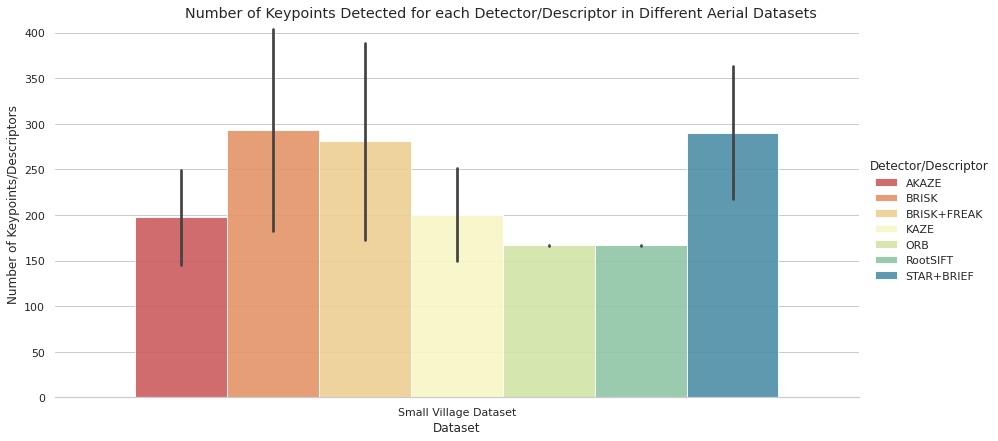

In [160]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_7, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [ ]:
df_numkey_7.to_csv(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [134]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_akaze + num_matches_brisk + num_matches_freak + num_matches_kaze + num_matches_orb + num_matches_rootsift + num_matches_briefstar, 'Detector/Descriptor': ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['KAZE']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1)  + ['STAR+BRIEF']*(len_files-1)  }
df_match_7 = pd.DataFrame(data=d)
df_match_7['Number of Total Matches'] = df_match_7['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

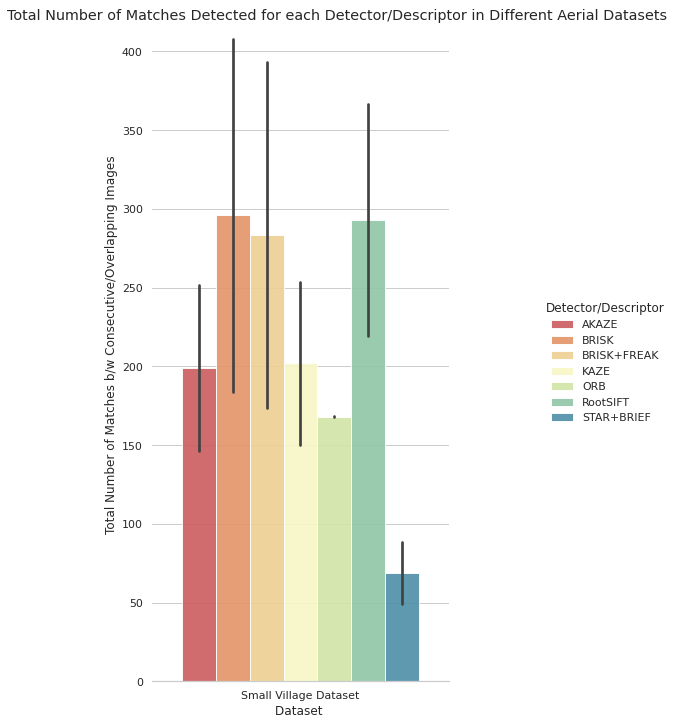

In [135]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [136]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [137]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [138]:
df_match_7['Number of Good Matches'] = num_good_matches_akaze + num_good_matches_brisk + num_good_matches_freak + num_good_matches_kaze + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_briefstar
df_match_7['Number of Good Matches'] = df_match_7['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

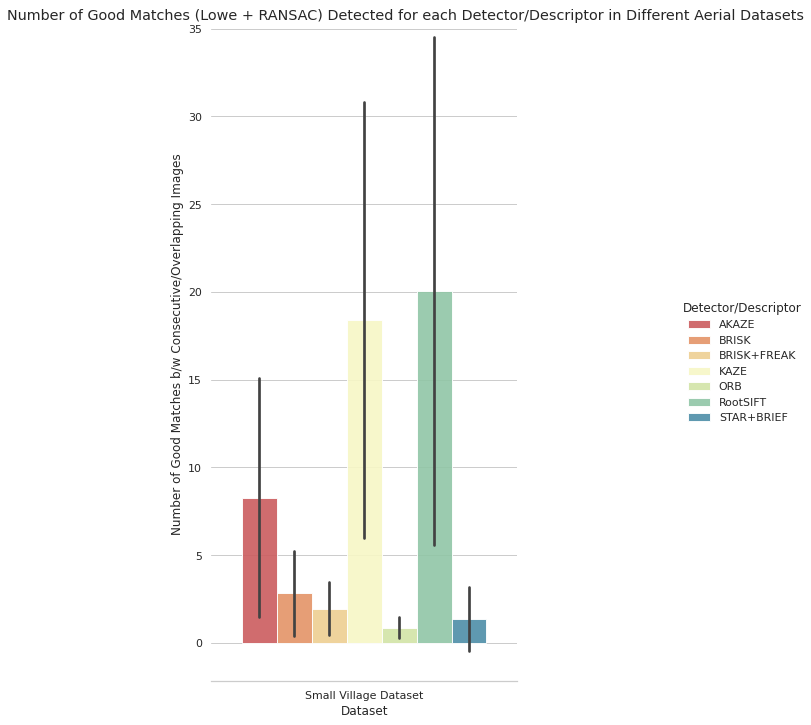

In [139]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [140]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [141]:
df_match_7['Recall Rate of Matches'] = df_match_7['Number of Good Matches']/df_match_7['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

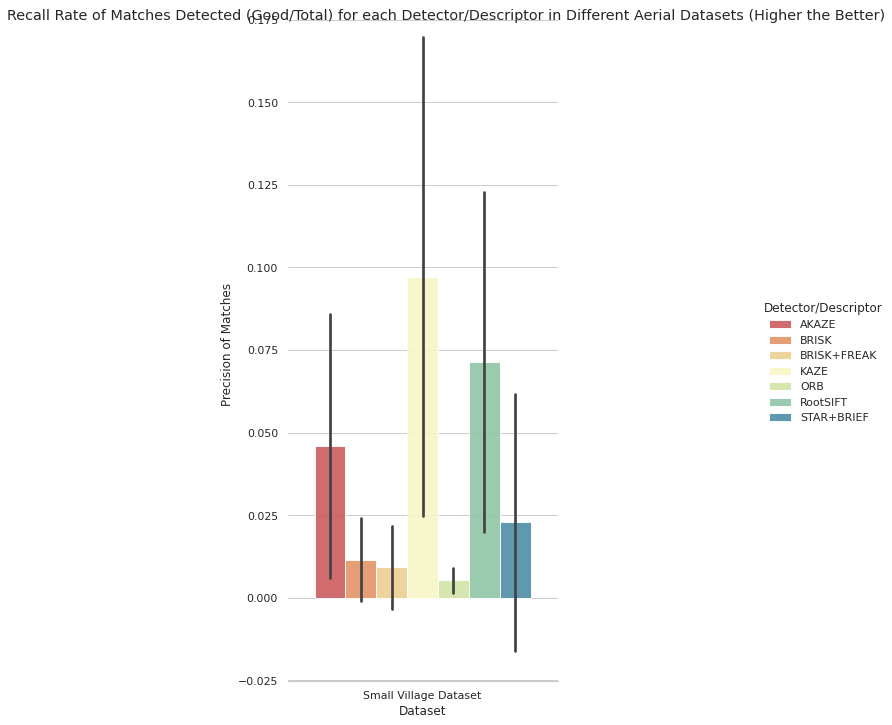

In [142]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [143]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [144]:
df_match_7 ['1 - Precision Rate of Matches'] = (df_match_7['Number of Total Matches'] - df_match_7['Number of Good Matches'])/df_match_7['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

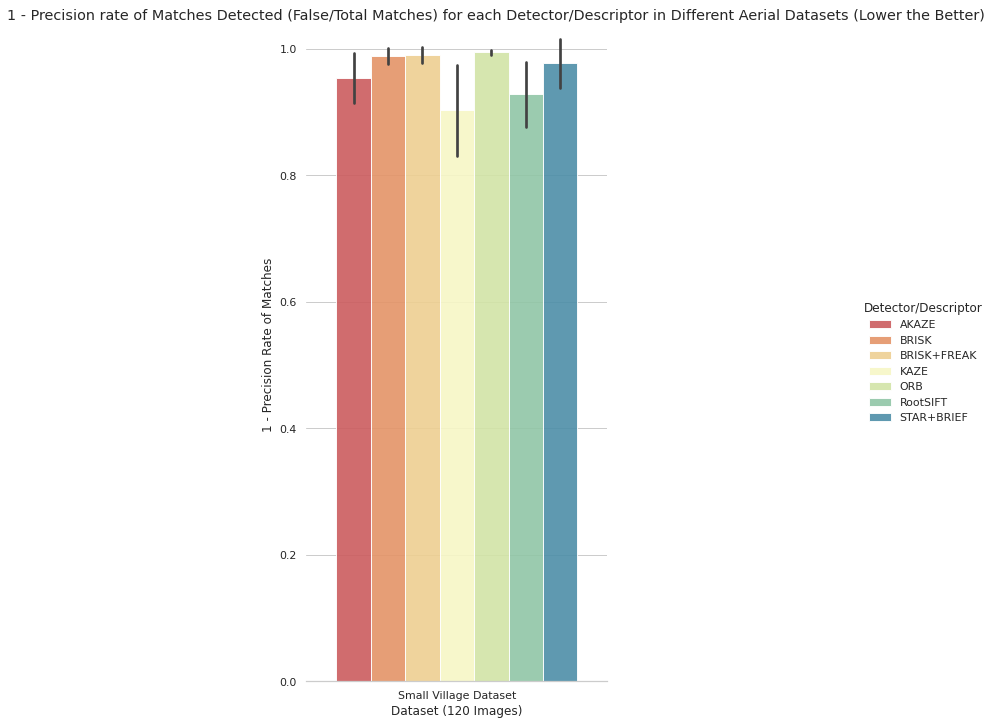

In [145]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [146]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [147]:
df_match_7['F-Score'] = (2* (1 - df_match_7['1 - Precision Rate of Matches']) * df_match_7['Recall Rate of Matches'])/((1 - df_match_7['1 - Precision Rate of Matches']) + df_match_7['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

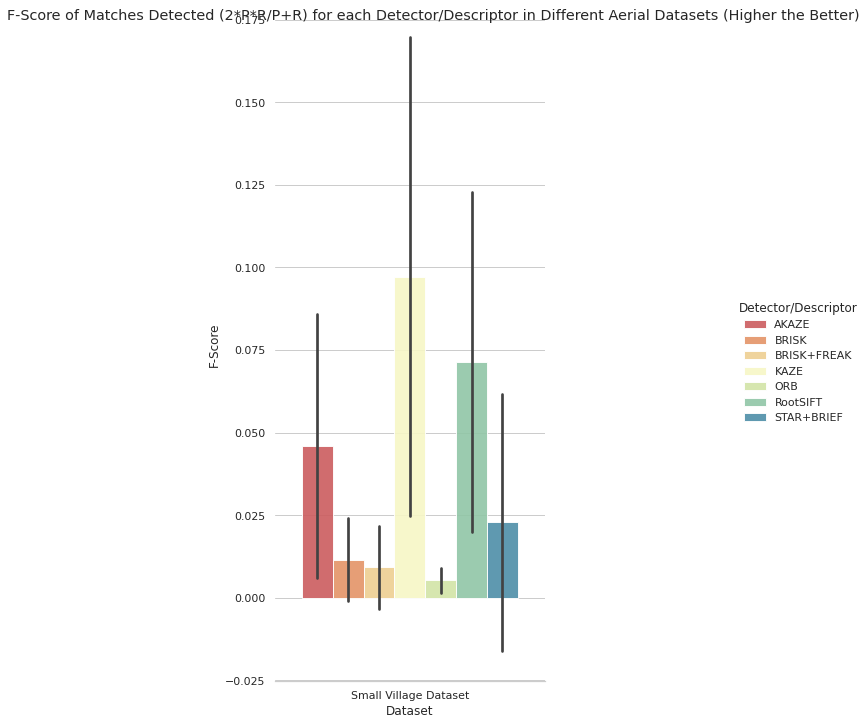

In [148]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [149]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [150]:
df_match_7.to_csv('drive/MyDrive/All_metrics_7.csv')

Time for each Detector+Descriptor

In [151]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AKAZE'] + ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['KAZE']*(1) +  ['ORB']*(1) +['RootSIFT']*(1) + ['STAR+BRIEF']*(1) }
df_time_7 = pd.DataFrame(data=d)

In [152]:
print(df_time_7)

                 Dataset         Time Detector/Descriptor
0  Small Village Dataset  1539.989971               AKAZE
1  Small Village Dataset   144.343611               BRISK
2  Small Village Dataset    33.656731         BRISK+FREAK
3  Small Village Dataset    40.518872                KAZE
4  Small Village Dataset   121.443888                 ORB
5  Small Village Dataset    40.717622            RootSIFT
6  Small Village Dataset   256.859849          STAR+BRIEF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

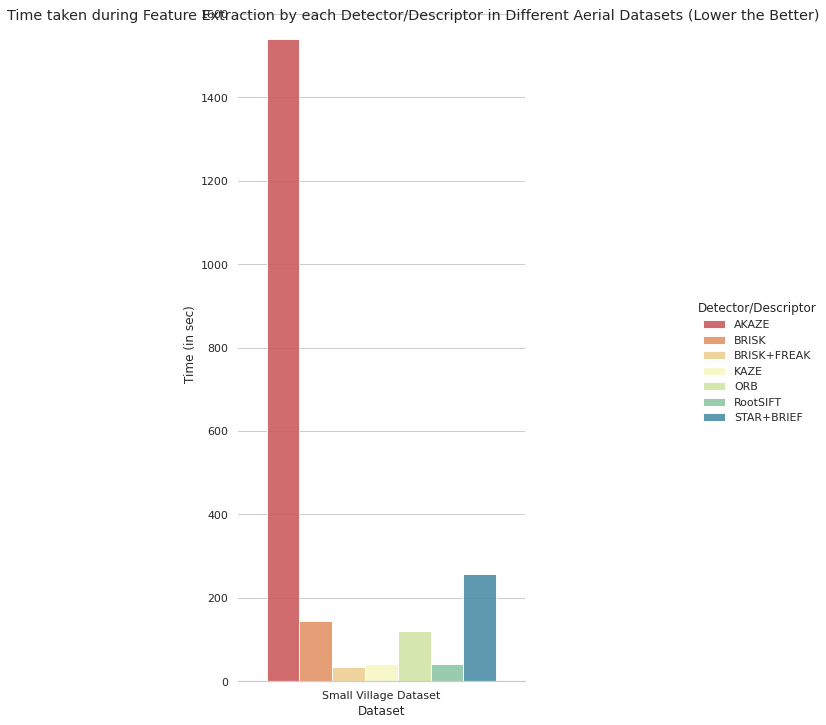

In [153]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_7, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [154]:
g.savefig('drive/MyDrive/Time_7.png')

In [155]:
df_time_7.to_csv('drive/MyDrive/Time_7.csv')

Stitching with CPU

In [ ]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_akaze + num_kps_brisk + num_kps_freak + num_kps_kaze + num_kps_orb + num_kps_rootsift + num_kps_star, 'Detector/Descriptor': ['AKAZE']*len_files + ['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['KAZE']*len_files + ['ORB']*len_files + ['RootSIFT']*len_files + ['STAR+BRIEF']*len_files  }
df_numkey_7 = pd.DataFrame(data=d)
df_numkey_7['Number of Keypoints'] = df_numkey_7['Number of Keypoints']/(len_files)